In [1]:
# ============================================================
# Cell 0
# Phase 2A — Reconstruction Independence Test
# Velocity Field: 2M++ (Carrick et al. 2015)
#
# Purpose:
#   Test whether filament-scale Eulerian circulation Γ(R)
#   depends on the velocity-field reconstruction.
#
# Non-negotiable constraints:
#   - Same filament sample and spine geometry as CF4 analysis
#   - Same circulation estimator Γ(R)
#   - Same radii, null tests, and robustness procedures
#   - Only the velocity field changes
#
# This notebook is strictly empirical and model-agnostic.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scientific I/O
from astropy.io import fits
from astropy.table import Table

# Utilities
import os
import sys
from pathlib import Path

print("Phase 2A notebook initialized.")
print("Reconstruction: 2M++ (Carrick et al. 2015)")

Phase 2A notebook initialized.
Reconstruction: 2M++ (Carrick et al. 2015)


In [2]:
# ============================================================
# Cell: 1
# INPUT LOADER — GOOGLE DRIVE (Phase 2A)
# Purpose:
#   Mount Drive and copy the 2M++ velocity grid into /content
#   for consistent, fast access by downstream analysis.
#
# Notes:
#   - twompp_velocity.npy is ~388 MB (expected size)
#   - File will be memory-mapped later to avoid RAM pressure
# ============================================================

from google.colab import drive
from pathlib import Path
import shutil

# --- Mount Google Drive ---
drive.mount("/content/drive")

# --- Paths (EDIT ONLY IF YOUR DRIVE FOLDER IS DIFFERENT) ---
DRIVE_BASE = Path("/content/drive/MyDrive")
VELGRID_SRC = DRIVE_BASE / "twompp_velocity.npy"

# Destination inside Colab runtime
CONTENT_BASE = Path("/content")
VELGRID_DST = CONTENT_BASE / "twompp_velocity.npy"

print("Looking for 2M++ velocity grid on Drive...")
print(" Source:", VELGRID_SRC)

if not VELGRID_SRC.exists():
    raise FileNotFoundError(f"2M++ velocity grid not found at {VELGRID_SRC}")

# --- Copy only if not already present (idempotent) ---
if not VELGRID_DST.exists():
    print("Copying 2M++ velocity grid into /content (this may take ~1 minute)...")
    shutil.copy(VELGRID_SRC, VELGRID_DST)
else:
    print("2M++ velocity grid already present in /content")

# --- Final confirmation ---
size_mb = VELGRID_DST.stat().st_size / (1024**2)
print(f"2M++ velocity grid ready: {VELGRID_DST} ({size_mb:.1f} MB)")

Mounted at /content/drive
Looking for 2M++ velocity grid on Drive...
 Source: /content/drive/MyDrive/twompp_velocity.npy
Copying 2M++ velocity grid into /content (this may take ~1 minute)...
2M++ velocity grid ready: /content/twompp_velocity.npy (388.5 MB)


In [5]:
# ============================================================
# CELL 2 — 2M++ GRID INSPECTION (RAM-safe)
# Loads using memory-mapping (does NOT read full array into RAM)
# Reports:
#   - dtype
#   - shape
#   - min/max (sampled)
#   - axis-order guess (3,Nx,Ny,Nz) vs (Nx,Ny,Nz,3)
# ============================================================

import numpy as np
from pathlib import Path

VELGRID_PATH = Path("/content/twompp_velocity.npy")
assert VELGRID_PATH.exists(), f"Missing: {VELGRID_PATH}"

V = np.load(VELGRID_PATH, mmap_mode="r")  # RAM-safe
print("[OK] Memory-mapped 2M++ velocity grid")
print("dtype:", V.dtype)
print("shape:", V.shape)

# Basic structural inference
axis_order_guess = None
if len(V.shape) == 4:
    if V.shape[0] == 3:
        axis_order_guess = "(3, Nx, Ny, Nz)  => components-first [vx,vy,vz]"
    elif V.shape[-1] == 3:
        axis_order_guess = "(Nx, Ny, Nz, 3)  => components-last [vx,vy,vz]"
    else:
        axis_order_guess = "4D but no obvious 3-component axis (check file creator)"
elif len(V.shape) == 3:
    axis_order_guess = "3D scalar grid (unexpected for velocity; did you store speed magnitude?)"
else:
    axis_order_guess = f"Unexpected ndim={len(V.shape)}"

print("axis-order guess:", axis_order_guess)

# Quick sampled stats (doesn't scan whole array)
rng = np.random.default_rng(0)
def sample_values(arr, n=20000):
    # sample random indices safely
    if arr.ndim == 4:
        idx = tuple(rng.integers(0, s, size=n) for s in arr.shape)
        vals = arr[idx]
    elif arr.ndim == 3:
        idx = tuple(rng.integers(0, s, size=n) for s in arr.shape)
        vals = arr[idx]
    else:
        vals = arr.reshape(-1)[:min(n, arr.size)]
    vals = np.asarray(vals).astype(np.float64)
    vals = vals[np.isfinite(vals)]
    return vals

vals = sample_values(V, n=20000)
print(f"sample finite count: {len(vals):,}")
if len(vals) > 0:
    print("sample min/max:", float(np.min(vals)), float(np.max(vals)))
    print("sample mean/std:", float(np.mean(vals)), float(np.std(vals)))
else:
    print("[WARN] No finite samples found (possible NaNs/inf everywhere?)")

[OK] Memory-mapped 2M++ velocity grid
dtype: float64
shape: (3, 257, 257, 257)
axis-order guess: (3, Nx, Ny, Nz)  => components-first [vx,vy,vz]
sample finite count: 20,000
sample min/max: -1168.5892834526542 1037.347325468008
sample mean/std: -13.018474361310687 153.36312849458938


In [6]:
# ============================================================
# CELL 8 — COPY FROZEN FILAMENT GEOMETRY TABLE (Phase 2A)
# Frozen input for all downstream analysis.
# Source:
#   gate3A_outputs/run_20260203_231537/filament_master_table_stage2.csv
# ============================================================

from pathlib import Path
import shutil
import pandas as pd

SRC = Path("/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/filament_master_table_stage2.csv")
DST = Path("/content/filaments_stage1_spines.csv")

assert SRC.exists(), f"Missing source geometry table: {SRC}"
shutil.copy(SRC, DST)

print("[OK] Copied geometry table")
print(" SRC:", SRC)
print(" DST:", DST)
print(" Size MB:", DST.stat().st_size / (1024**2))

# Quick verification
df = pd.read_csv(DST)
print("\n[VERIFY] rows, cols:", df.shape)
print("[VERIFY] columns (first 25):", list(df.columns)[:25])
display(df.head(3))

[OK] Copied geometry table
 SRC: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/filament_master_table_stage2.csv
 DST: /content/filaments_stage1_spines.csv
 Size MB: 10.065500259399414

[VERIFY] rows, cols: (81330, 15)
[VERIFY] columns (first 25): ['cp0', 'cp1', 'npts', 'x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'cx', 'cy', 'cz', 'length_native', 'cpA', 'cpB']


,cp0,cp1,npts,x0,y0,z0,x1,y1,z1,cx,cy,cz,length_native,cpA,cpB
0,0,0,4,749.560,464.465,493.400,714.769,486.158,511.365,731.6380,472.4675,502.47675,49.926952,9811,9812
1,1,0,5,749.560,464.465,493.400,793.483,472.017,474.724,778.4584,469.8006,488.31600,59.609085,9811,9814
2,2,0,5,714.769,486.158,511.365,711.295,437.912,530.140,711.7924,457.9978,519.57860,57.547755,9812,9813


In [7]:
# ==========================================================
# Cell 8b — Geometry Verification / Sanity Check
# ==========================================================

import pandas as pd
df = pd.read_csv("/content/filaments_stage1_spines.csv")
print("rows, cols:", df.shape)
print("columns:", list(df.columns)[:30])
display(df.head(3))

rows, cols: (81330, 15)
columns: ['cp0', 'cp1', 'npts', 'x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'cx', 'cy', 'cz', 'length_native', 'cpA', 'cpB']


,cp0,cp1,npts,x0,y0,z0,x1,y1,z1,cx,cy,cz,length_native,cpA,cpB
0,0,0,4,749.560,464.465,493.400,714.769,486.158,511.365,731.6380,472.4675,502.47675,49.926952,9811,9812
1,1,0,5,749.560,464.465,493.400,793.483,472.017,474.724,778.4584,469.8006,488.31600,59.609085,9811,9814
2,2,0,5,714.769,486.158,511.365,711.295,437.912,530.140,711.7924,457.9978,519.57860,57.547755,9812,9813


In [8]:
# ============================================================
# Cell 9 - DERIVE 2M++ GRID GEOMETRY FROM FILAMENT DATA
# Purpose:
#   Define grid center + halfsize so that the 2M++ velocity cube
#   fully covers the frozen filament geometry (no silent clipping).
# ============================================================

import numpy as np
import pandas as pd

# Load frozen filament geometry
df = pd.read_csv("/content/filaments_stage1_spines.csv")

# Collect all endpoint coordinates
xs = np.concatenate([df["x0"].values, df["x1"].values])
ys = np.concatenate([df["y0"].values, df["y1"].values])
zs = np.concatenate([df["z0"].values, df["z1"].values])

# Bounding box of filament geometry
xmin, xmax = float(xs.min()), float(xs.max())
ymin, ymax = float(ys.min()), float(ys.max())
zmin, zmax = float(zs.min()), float(zs.max())

# Derived center
cx = 0.5 * (xmin + xmax)
cy = 0.5 * (ymin + ymax)
cz = 0.5 * (zmin + zmax)

# Required halfsize (max extent, padded by 5%)
hx = 0.5 * (xmax - xmin)
hy = 0.5 * (ymax - ymin)
hz = 0.5 * (zmax - zmin)
halfsize_required = 1.05 * max(hx, hy, hz)

print("=== FILAMENT GEOMETRY EXTENT ===")
print(f"x: [{xmin:.3f}, {xmax:.3f}]")
print(f"y: [{ymin:.3f}, {ymax:.3f}]")
print(f"z: [{zmin:.3f}, {zmax:.3f}]")

print("\n=== RECOMMENDED 2M++ GRID GEOMETRY ===")
print(f"GRID_CENTER_XYZ = ({cx:.6f}, {cy:.6f}, {cz:.6f})")
print(f"GRID_HALFSIZE   = {halfsize_required:.6f}")

print("\nACTION:")
print("Copy these values verbatim into Cell 5 (grid geometry block),")
print("then re-run Cell 5 before proceeding.")

=== FILAMENT GEOMETRY EXTENT ===
x: [0.026, 3245.430]
y: [-2911.870, 3229.860]
z: [-1720.890, 1915.340]

=== RECOMMENDED 2M++ GRID GEOMETRY ===
GRID_CENTER_XYZ = (1622.727837, 158.995000, 97.225000)
GRID_HALFSIZE   = 3224.408250

ACTION:
Copy these values verbatim into Cell 5 (grid geometry block),
then re-run Cell 5 before proceeding.


In [9]:
# ============================================================
# CELL 10 — 2M++ VELOCITY BACKEND (FINAL, Phase 2A)
#
# Grid geometry fixed from Cell 9 (derived from frozen filaments).
# This cell replaces Cell 5.
#
# Phase-2A rule:
#   - Γ(R) estimator unchanged
#   - filament geometry unchanged
#   - ONLY velocity field backend changes
# ============================================================


import numpy as np
from scipy.interpolate import RegularGridInterpolator
from pathlib import Path

# --- Load memory-mapped 2M++ velocity cube ---
VELGRID_PATH = Path("/content/twompp_velocity.npy")
assert VELGRID_PATH.exists(), f"Missing 2M++ grid: {VELGRID_PATH}"

V = np.load(VELGRID_PATH, mmap_mode="r")  # expected shape (3,257,257,257)
assert V.ndim == 4 and V.shape[0] == 3, f"Unexpected V shape: {V.shape}"

Nx, Ny, Nz = V.shape[1], V.shape[2], V.shape[3]
print(f"[OK] Loaded 2M++ grid V with shape (3,{Nx},{Ny},{Nz}) | dtype={V.dtype}")

# ============================================================
# GRID GEOMETRY — DERIVED FROM FROZEN FILAMENT DATA (Cell 9)
# Coordinate system must match filament geometry table (x0,y0,z0 etc.)
# ============================================================

GRID_CENTER_XYZ = (1622.727837, 158.995000, 97.225000)
GRID_HALFSIZE   = 3224.408250

# --- Derived coordinate axes (uniform grid) ---
x0, y0, z0 = GRID_CENTER_XYZ
x = np.linspace(x0 - GRID_HALFSIZE, x0 + GRID_HALFSIZE, Nx)
y = np.linspace(y0 - GRID_HALFSIZE, y0 + GRID_HALFSIZE, Ny)
z = np.linspace(z0 - GRID_HALFSIZE, z0 + GRID_HALFSIZE, Nz)

dx, dy, dz = float(x[1] - x[0]), float(y[1] - y[0]), float(z[1] - z[0])
print(f"[GRID] Center = {GRID_CENTER_XYZ} | halfsize = {GRID_HALFSIZE}")
print(f"[GRID] N = ({Nx},{Ny},{Nz}) | spacing = ({dx:.6g}, {dy:.6g}, {dz:.6g}) in filament units")

# ============================================================
# Interpolators (vx, vy, vz) on (x,y,z)
# RegularGridInterpolator expects data shaped (Nx,Ny,Nz) for the axes order.
# ============================================================

vx_grid = np.asarray(V[0])  # memmap-backed view, shape (Nx,Ny,Nz)
vy_grid = np.asarray(V[1])
vz_grid = np.asarray(V[2])

_vx = RegularGridInterpolator((x, y, z), vx_grid, bounds_error=False, fill_value=np.nan)
_vy = RegularGridInterpolator((x, y, z), vy_grid, bounds_error=False, fill_value=np.nan)
_vz = RegularGridInterpolator((x, y, z), vz_grid, bounds_error=False, fill_value=np.nan)

def vel_2mpp_xyz(xq, yq, zq):
    """
    Trilinear-interpolated velocity from the 2M++ cube.

    Parameters
    ----------
    xq, yq, zq : float or array-like
        Query coordinates in the SAME frame/units as filament geometry.

    Returns
    -------
    (vx, vy, vz) : np.ndarray
        Arrays broadcast to the shape of (xq,yq,zq). Values outside the cube are NaN.
    """
    xq = np.asarray(xq, dtype=float)
    yq = np.asarray(yq, dtype=float)
    zq = np.asarray(zq, dtype=float)
    X, Y, Z = np.broadcast_arrays(xq, yq, zq)
    pts = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=-1)
    vx = _vx(pts).reshape(X.shape)
    vy = _vy(pts).reshape(X.shape)
    vz = _vz(pts).reshape(X.shape)
    return vx, vy, vz

# ============================================================
# Self-test at cube center
# ============================================================

vtest = vel_2mpp_xyz(x0, y0, z0)
print("[TEST] v(center) =", tuple(float(v) for v in vtest))

[OK] Loaded 2M++ grid V with shape (3,257,257,257) | dtype=float64
[GRID] Center = (1622.727837, 158.995, 97.225) | halfsize = 3224.40825
[GRID] N = (257,257,257) | spacing = (25.1907, 25.1907, 25.1907) in filament units
[TEST] v(center) = (66.1644930831987, -576.2609372148086, 402.53849541480827)


In [10]:
# ============================================================
# CELL 11 — DOMAIN COVERAGE CHECK (Phase 2A)
# Purpose:
#   Quantify what fraction of frozen filament segment endpoints
#   lie inside the 2M++ velocity cube domain.
#
# Inputs:
#   /content/filaments_stage1_spines.csv  (segment geometry table)
#   x,y,z axes defined in Cell 10 (2M++ grid geometry)
# ============================================================

import numpy as np
import pandas as pd

# Load frozen segment geometry
df = pd.read_csv("/content/filaments_stage1_spines.csv")

# Endpoints
x0 = df["x0"].to_numpy(float); y0 = df["y0"].to_numpy(float); z0 = df["z0"].to_numpy(float)
x1 = df["x1"].to_numpy(float); y1 = df["y1"].to_numpy(float); z1 = df["z1"].to_numpy(float)

# Domain bounds from Cell 10 axes (assumes x,y,z are in scope)
xmin, xmax = float(x.min()), float(x.max())
ymin, ymax = float(y.min()), float(y.max())
zmin, zmax = float(z.min()), float(z.max())

def inside(xx, yy, zz):
    return (xx >= xmin) & (xx <= xmax) & (yy >= ymin) & (yy <= ymax) & (zz >= zmin) & (zz <= zmax)

in0 = inside(x0, y0, z0)
in1 = inside(x1, y1, z1)

# Fraction endpoints inside
frac0 = float(np.mean(in0))
frac1 = float(np.mean(in1))
frac_any = float(np.mean(in0 | in1))
frac_both = float(np.mean(in0 & in1))

print("=== 2M++ CUBE DOMAIN ===")
print(f"x: [{xmin:.3f}, {xmax:.3f}]")
print(f"y: [{ymin:.3f}, {ymax:.3f}]")
print(f"z: [{zmin:.3f}, {zmax:.3f}]")

print("\n=== FROZEN FILAMENT ENDPOINT COVERAGE ===")
print(f"Endpoints (x0,y0,z0) inside: {frac0:.6f}")
print(f"Endpoints (x1,y1,z1) inside: {frac1:.6f}")
print(f"Segments with >=1 endpoint inside: {frac_any:.6f}")
print(f"Segments with BOTH endpoints inside: {frac_both:.6f}")

# If anything is outside, show a few examples
n_out = int(np.sum(~(in0 & in1)))
print(f"\nSegments with at least one endpoint outside: {n_out}")

if n_out > 0:
    idx = np.where(~(in0 & in1))[0][:5]
    print("\nFirst 5 out-of-domain segments (index, cp0, cp1, x0,y0,z0, x1,y1,z1):")
    for i in idx:
        r = df.iloc[i]
        print(f"  {int(r['index']) if 'index' in df.columns else i:6d} | cp0={int(r['cp0'])} cp1={int(r['cp1'])} | "
              f"({r['x0']:.3f},{r['y0']:.3f},{r['z0']:.3f}) -> ({r['x1']:.3f},{r['y1']:.3f},{r['z1']:.3f})")
else:
    print("\n[OK] All segment endpoints are inside the 2M++ cube.")

=== 2M++ CUBE DOMAIN ===
x: [-1601.680, 4847.136]
y: [-3065.413, 3383.403]
z: [-3127.183, 3321.633]

=== FROZEN FILAMENT ENDPOINT COVERAGE ===
Endpoints (x0,y0,z0) inside: 1.000000
Endpoints (x1,y1,z1) inside: 1.000000
Segments with >=1 endpoint inside: 1.000000
Segments with BOTH endpoints inside: 1.000000

Segments with at least one endpoint outside: 0

[OK] All segment endpoints are inside the 2M++ cube.


In [11]:
# ============================================================
# CELL 12 — 2M++ VELOCITY QUERY SANITY CHECK (Phase 2A)
# Purpose:
#   Ensure vel_2mpp_xyz returns finite values across typical
#   segment-interior query points (not just endpoints).
# ============================================================

import numpy as np
import pandas as pd

df = pd.read_csv("/content/filaments_stage1_spines.csv")

# Pull endpoints
x0 = df["x0"].to_numpy(float); y0 = df["y0"].to_numpy(float); z0 = df["z0"].to_numpy(float)
x1 = df["x1"].to_numpy(float); y1 = df["y1"].to_numpy(float); z1 = df["z1"].to_numpy(float)

Nseg = len(df)
rng = np.random.default_rng(0)

# sample segments
nsamp_seg = min(2000, Nseg)
idx = rng.choice(Nseg, size=nsamp_seg, replace=False)

# sample 3 interior t-values per segment (including midpoint)
tvals = np.array([0.25, 0.50, 0.75], dtype=float)

# build query points
Xq = []
Yq = []
Zq = []

for i in idx:
    for t in tvals:
        Xq.append((1-t)*x0[i] + t*x1[i])
        Yq.append((1-t)*y0[i] + t*y1[i])
        Zq.append((1-t)*z0[i] + t*z1[i])

Xq = np.asarray(Xq); Yq = np.asarray(Yq); Zq = np.asarray(Zq)

vx, vy, vz = vel_2mpp_xyz(Xq, Yq, Zq)

finite = np.isfinite(vx) & np.isfinite(vy) & np.isfinite(vz)
frac_finite = float(np.mean(finite))
n_bad = int(np.sum(~finite))

speed = np.sqrt(vx**2 + vy**2 + vz**2)
speed_f = speed[np.isfinite(speed)]

print("=== 2M++ VELOCITY QUERY SANITY CHECK ===")
print(f"Segments sampled: {nsamp_seg} | points per segment: {len(tvals)} | total query points: {len(Xq)}")
print(f"Finite (vx,vy,vz) fraction: {frac_finite:.6f}")
print(f"Non-finite points: {n_bad}")

if len(speed_f) > 0:
    print("\nSpeed |v| stats (sampled points):")
    print(f"min/median/max: {float(np.min(speed_f)):.3f} / {float(np.median(speed_f)):.3f} / {float(np.max(speed_f)):.3f}")
    print(f"mean/std: {float(np.mean(speed_f)):.3f} / {float(np.std(speed_f)):.3f}")
else:
    print("[WARN] No finite speed values found — investigate immediately.")

# Show a few problematic points if any
if n_bad > 0:
    bad_idx = np.where(~finite)[0][:5]
    print("\nFirst 5 non-finite query points (x,y,z):")
    for j in bad_idx:
        print(f"  ({Xq[j]:.3f}, {Yq[j]:.3f}, {Zq[j]:.3f})")

=== 2M++ VELOCITY QUERY SANITY CHECK ===
Segments sampled: 2000 | points per segment: 3 | total query points: 6000
Finite (vx,vy,vz) fraction: 1.000000
Non-finite points: 0

Speed |v| stats (sampled points):
min/median/max: 10.846 / 335.622 / 1071.455
mean/std: 363.313 / 164.916


In [ ]:
# ============================================================
# CELL 13 — Γ(R) SMOKE TEST (Phase 2A, 2M++)
# Purpose:
#   Minimal end-to-end circulation computation on a small subset
#   of segments at one radius. Confirms geometry+basis+velocity backend.
#
# NOTE:
#   This does NOT replace the canonical Γ(R) estimator cell you already have.
#   It is a smoke test only.
# ============================================================

import numpy as np
import pandas as pd

df = pd.read_csv("/content/filaments_stage1_spines.csv")

# --- Parameters (match your canonical settings) ---
R = 2.0        # Mpc (use one of your canonical radii; adjust if you want)
NPHI = 64      # should match your frozen NPHI
NSEG_TEST = 20 # tiny subset

# Pull endpoints and centers
x0 = df["x0"].to_numpy(float); y0 = df["y0"].to_numpy(float); z0 = df["z0"].to_numpy(float)
x1 = df["x1"].to_numpy(float); y1 = df["y1"].to_numpy(float); z1 = df["z1"].to_numpy(float)
cx = df["cx"].to_numpy(float); cy = df["cy"].to_numpy(float); cz = df["cz"].to_numpy(float)

# Choose deterministic subset (first N rows) for reproducibility
idx = np.arange(min(NSEG_TEST, len(df)))

phis = np.linspace(0, 2*np.pi, NPHI, endpoint=False)
dphi = 2*np.pi / NPHI

def unit(v):
    n = np.linalg.norm(v)
    if n == 0:
        return v
    return v / n

Gammas = []

for i in idx:
    p0 = np.array([x0[i], y0[i], z0[i]], dtype=float)
    p1 = np.array([x1[i], y1[i], z1[i]], dtype=float)
    c  = np.array([cx[i], cy[i], cz[i]], dtype=float)

    # Segment axis (tangent)
    t = unit(p1 - p0)

    # Build an orthonormal basis (e1, e2) perpendicular to t
    # Pick a helper vector not parallel to t
    helper = np.array([0.0, 0.0, 1.0])
    if abs(np.dot(t, helper)) > 0.9:
        helper = np.array([0.0, 1.0, 0.0])

    e1 = unit(np.cross(t, helper))
    e2 = unit(np.cross(t, e1))

    # Ring points around segment center
    Xq = c[0] + R*(np.cos(phis)*e1[0] + np.sin(phis)*e2[0])
    Yq = c[1] + R*(np.cos(phis)*e1[1] + np.sin(phis)*e2[1])
    Zq = c[2] + R*(np.cos(phis)*e1[2] + np.sin(phis)*e2[2])

    vx, vy, vz = vel_2mpp_xyz(Xq, Yq, Zq)
    v = np.stack([vx, vy, vz], axis=-1)  # (NPHI,3)

    # Tangent direction along the ring (right-hand around +t)
    # dr/dphi = R*(-sin phi e1 + cos phi e2)
    tphi = (-np.sin(phis)[:,None]*e1[None,:] + np.cos(phis)[:,None]*e2[None,:])
    # Unit tangent
    tphi = tphi / np.linalg.norm(tphi, axis=1)[:,None]

    # Integrand v · tphi, approximating line integral Γ ≈ Σ (v·tphi) * (R dphi)
    vdot = np.sum(v * tphi, axis=1)
    Gamma = np.sum(vdot) * (R * dphi)

    Gammas.append(Gamma)

Gammas = np.array(Gammas, dtype=float)

print("=== Γ(R) SMOKE TEST (2M++ backend) ===")
print(f"R = {R} | NPHI = {NPHI} | N segments = {len(Gammas)}")
print("Gamma stats (raw, signed):")
print(f"min/median/max: {float(np.min(Gammas)):.6g} / {float(np.median(Gammas)):.6g} / {float(np.max(Gammas)):.6g}")
print(f"mean/std: {float(np.mean(Gammas)):.6g} / {float(np.std(Gammas)):.6g}")
print("Mean |Gamma|:", float(np.mean(np.abs(Gammas))))

=== Γ(R) SMOKE TEST (2M++ backend) ===
R = 2.0 | NPHI = 64 | N segments = 20
Gamma stats (raw, signed):
min/median/max: -2.31861 / -0.0506798 / 3.18891
mean/std: -0.0371583 / 1.01149
Mean |Gamma|: 0.5914460717884538


In [12]:
# ============================================================
# CELL 14 — PHASE 2A CORE METRIC (2M++)
# Compute frozen statistic: <|Γ(R)|> across canonical radii
#
# Canonical settings (per Gate 3A lock-in):
#   Radii: [2,4,6,8,10,12,15,20] Mpc
#   NPHI: 64
#
# Output:
#   DataFrame with mean(|Γ|) vs R for a deterministic subset of segments.
# ============================================================

import numpy as np
import pandas as pd

# --- Canonical radii & sampling ---
RADII = np.array([2,4,6,8,10,12,15,20], dtype=float)
NPHI = 64

# --- Load frozen segment geometry ---
df = pd.read_csv("/content/filaments_stage1_spines.csv")

# Pull endpoints and centers
x0 = df["x0"].to_numpy(float); y0 = df["y0"].to_numpy(float); z0 = df["z0"].to_numpy(float)
x1 = df["x1"].to_numpy(float); y1 = df["y1"].to_numpy(float); z1 = df["z1"].to_numpy(float)
cx = df["cx"].to_numpy(float); cy = df["cy"].to_numpy(float); cz = df["cz"].to_numpy(float)

# ------------------------------------------------------------
# Deterministic subset selection (replication-safe)
# If you already have a frozen subset file, plug it here.
# Otherwise: use the first N segments deterministically.
# ------------------------------------------------------------
N_SEG = 1500  # match your frozen N; safe fallback if table is segment-level
N_SEG = min(N_SEG, len(df))
seg_idx = np.arange(N_SEG)  # deterministic baseline

phis = np.linspace(0, 2*np.pi, NPHI, endpoint=False)
dphi = 2*np.pi / NPHI

def unit(v):
    n = np.linalg.norm(v)
    return v if n == 0 else (v / n)

def gamma_for_segment_radius(i, R):
    p0 = np.array([x0[i], y0[i], z0[i]], dtype=float)
    p1 = np.array([x1[i], y1[i], z1[i]], dtype=float)
    c  = np.array([cx[i], cy[i], cz[i]], dtype=float)

    t = unit(p1 - p0)

    helper = np.array([0.0, 0.0, 1.0])
    if abs(np.dot(t, helper)) > 0.9:
        helper = np.array([0.0, 1.0, 0.0])

    e1 = unit(np.cross(t, helper))
    e2 = unit(np.cross(t, e1))

    Xq = c[0] + R*(np.cos(phis)*e1[0] + np.sin(phis)*e2[0])
    Yq = c[1] + R*(np.cos(phis)*e1[1] + np.sin(phis)*e2[1])
    Zq = c[2] + R*(np.cos(phis)*e1[2] + np.sin(phis)*e2[2])

    vx, vy, vz = vel_2mpp_xyz(Xq, Yq, Zq)
    v = np.stack([vx, vy, vz], axis=-1)

    tphi = (-np.sin(phis)[:,None]*e1[None,:] + np.cos(phis)[:,None]*e2[None,:])
    tphi = tphi / np.linalg.norm(tphi, axis=1)[:,None]

    vdot = np.sum(v * tphi, axis=1)
    return float(np.sum(vdot) * (R * dphi))

# --- Compute mean(|Γ|) vs R ---
rows = []
for R in RADII:
    G = np.array([gamma_for_segment_radius(i, R) for i in seg_idx], dtype=float)
    rows.append({
        "R_mpc": float(R),
        "N_segments": int(len(G)),
        "mean_abs_Gamma": float(np.mean(np.abs(G))),
        "median_abs_Gamma": float(np.median(np.abs(G))),
    })

out = pd.DataFrame(rows)
print("=== Phase 2A (2M++): <|Γ(R)|> ===")
display(out)

=== Phase 2A (2M++): <|Γ(R)|> ===


,R_mpc,N_segments,mean_abs_Gamma,median_abs_Gamma
0,2.0,1500,0.474464,0.292954
1,4.0,1500,1.636656,1.012415
2,6.0,1500,3.123182,2.007036
3,8.0,1500,4.576088,2.941760
4,10.0,1500,5.678625,3.725041
5,12.0,1500,6.157070,4.098582
6,15.0,1500,5.745508,3.833059
7,20.0,1500,6.647916,4.550660


In [13]:
# ============================================================
# CELL 15a — LOCATE FROZEN GATE 3A SUBSET FILE ON DRIVE
# Purpose:
#   Find the correct "...Asymmetry_vs_Omega...FIL.csv" (or equivalent)
#   anywhere under /content/drive/MyDrive/SFH_filaments, then print a
#   copy-pasteable FROZEN_PATH for Cell 15.
# ============================================================

from pathlib import Path

ROOT = Path("/content/drive/MyDrive/SFH_filaments")
assert ROOT.exists(), f"Missing ROOT folder: {ROOT}"

patterns = [
    "*Asymmetry*Omega*FIL*.csv",
    "*Asymmetry*Omega*fil*.csv",
    "*Asymmetry_vs_Omega*FIL*.csv",
    "*Asymmetry_vs_Omega*fil*.csv",
    "*Asymmetry*Omega*.csv",
    "*CYL*Asymmetry*Omega*FIL*.csv",
]

hits = []
for pat in patterns:
    hits += list(ROOT.rglob(pat))

# de-dupe + sort by size (largest first), then path
hits = sorted(set([h for h in hits if h.is_file()]), key=lambda p: (-p.stat().st_size, str(p)))

print(f"Search root: {ROOT}")
print(f"Matches found: {len(hits)}")

if len(hits) == 0:
    print("[ERROR] No matching frozen-subset CSV found under SFH_filaments.")
    print("Fallback: we will instead read cp0 IDs from the geometry table itself (Cell 15b).")
else:
    print("\nTop matches (largest first):")
    for i, h in enumerate(hits[:15]):
        print(f"[{i:02d}] {h.stat().st_size/(1024**2):8.3f} MB | {h}")

    best = hits[0]
    print("\n[USE THIS IN CELL 15]")
    print(f'FROZEN_PATH = "{best}"')

Search root: /content/drive/MyDrive/SFH_filaments
Matches found: 0
[ERROR] No matching frozen-subset CSV found under SFH_filaments.
Fallback: we will instead read cp0 IDs from the geometry table itself (Cell 15b).


In [18]:
# ============================================================
# CELL 15b — DEFINE FROZEN FILAMENT SET FROM GEOMETRY TABLE
# Purpose:
#   Create the frozen filament-ID set directly from the segment
#   geometry you are using in Phase 2A (no external file needed).
# ============================================================

import pandas as pd

df = pd.read_csv("/content/filaments_stage1_spines.csv")

assert "cp0" in df.columns, "Expected column cp0 in geometry table."
cp0_ids = sorted(df["cp0"].astype(int).unique().tolist())

print("=== FROZEN FILAMENT SET (from geometry table) ===")
print("Unique cp0 count:", len(cp0_ids))
print("First 20 cp0 IDs:", cp0_ids[:20])
print("Last  20 cp0 IDs:", cp0_ids[-20:])

=== FROZEN FILAMENT SET (from geometry table) ===
Unique cp0 count: 63391
First 20 cp0 IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Last  20 cp0 IDs: [63371, 63372, 63373, 63374, 63375, 63376, 63377, 63378, 63379, 63380, 63381, 63382, 63383, 63384, 63385, 63386, 63387, 63388, 63389, 63390]


In [19]:
# ============================================================
# CELL 15c — LOCATE GATE 3A FROZEN SUBSET (top-by-maxAbsΓ) FILE
# Purpose:
#   Find the CSV/TXT created in Gate 3A that defines the frozen subset
#   (N=1500 filaments selected deterministically).
# ============================================================

from pathlib import Path

ROOT = Path("/content/drive/MyDrive/SFH_filaments")
assert ROOT.exists(), f"Missing ROOT: {ROOT}"

# Focus on gate3A outputs, but still robust to naming differences
search_roots = [
    ROOT / "gate3A_outputs",
    ROOT / "outputs",
    ROOT / "derived",
    ROOT
]

# Keywords that typically appear in your saved subset/pool files
KEYS = [
    "top", "subset", "pool", "carrier", "selected", "selection",
    "maxabs", "max_abs", "maxabsgamma", "max_abs_gamma", "rank",
    "gate3a", "g3a"
]

exts = {".csv", ".txt"}

hits = []
for base in search_roots:
    if not base.exists():
        continue
    for p in base.rglob("*"):
        if not p.is_file():
            continue
        if p.suffix.lower() not in exts:
            continue
        name = p.name.lower()
        if any(k in name for k in KEYS):
            hits.append(p)

# Sort by size (largest first), then name
hits = sorted(set(hits), key=lambda p: (-p.stat().st_size, str(p)))

print("Search roots checked:")
for b in search_roots:
    print(" -", b, "(exists)" if b.exists() else "(missing)")
print("\nMatches:", len(hits))

if len(hits) == 0:
    print("[ERROR] No obvious frozen-subset file found by keywords.")
    print("Next fallback: we’ll extract the subset directly from a REAL FIL table if present.")
else:
    print("\nTop 25 candidate files:")
    for i, p in enumerate(hits[:25]):
        print(f"[{i:02d}] {p.stat().st_size/(1024**2):8.3f} MB | {p}")

    best = hits[0]
    print("\n[TRY THIS FIRST]")
    print(f'FROZEN_SUBSET_PATH = "{best}"')

Search roots checked:
 - /content/drive/MyDrive/SFH_filaments/gate3A_outputs (exists)
 - /content/drive/MyDrive/SFH_filaments/outputs (exists)
 - /content/drive/MyDrive/SFH_filaments/derived (exists)
 - /content/drive/MyDrive/SFH_filaments (exists)

Matches: 314

Top 25 candidate files:
[00]   39.398 MB | /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv
[01]   39.398 MB | /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vphi_gamma_profiles_FIL.csv
[02]   23.140 MB | /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/G3A_null_axis_FILAMENTWISE.csv
[03]   23.140 MB | /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_null_axis_FILAMENTWISE.csv
[04]   21.385 MB | /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_profiles_SEG_merged.csv
[05]   21.385 MB | /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260206_185847/G3A_vph

In [14]:
# ============================================================
# CELL 15d — BUILD FROZEN SUBSET (top-by-max |Γ|) FROM GATE 3A FIL TABLE
# Fix:
#   This FIL table stores Γ(R) at multiple radii (Gamma_R2, Gamma_R4, ...),
#   so we define maxAbsGamma = max_R |Gamma_R|.
# ============================================================

import pandas as pd
import numpy as np

FIL_PATH = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv"
N_FROZEN = 1500

fil = pd.read_csv(FIL_PATH)
print("[OK] Loaded FIL table:", FIL_PATH)
print("rows, cols:", fil.shape)

assert "cp0" in fil.columns, "Expected 'cp0' column in FIL table."

# Find all Gamma_R* columns
gamma_cols = [c for c in fil.columns if c.lower().startswith("gamma_r")]
assert len(gamma_cols) > 0, f"No Gamma_R* columns found. Columns head: {list(fil.columns)[:40]}"

# Ensure numeric
for c in gamma_cols:
    fil[c] = pd.to_numeric(fil[c], errors="coerce")

# Compute maxAbsGamma across radii
fil["maxAbsGamma"] = np.nanmax(np.abs(fil[gamma_cols].to_numpy(float)), axis=1)

# Drop NaNs (rows with all-NaN gamma values)
fil2 = fil[["cp0", "maxAbsGamma"]].dropna().copy()

# Deterministic top-N selection
fil2 = fil2.sort_values("maxAbsGamma", ascending=False).reset_index(drop=True)
top = fil2.head(min(N_FROZEN, len(fil2))).copy()

frozen_cp0 = top["cp0"].astype(int).tolist()

print("\n=== FROZEN SUBSET (Gate 3A reproduction) ===")
print("Gamma columns used:", gamma_cols)
print("Requested N:", N_FROZEN)
print("Available non-NaN:", len(fil2))
print("Selected N:", len(frozen_cp0))
print("Top 10 cp0:", frozen_cp0[:10])
print("Bottom 10 cp0:", frozen_cp0[-10:])
print("Top maxAbsGamma:", float(top["maxAbsGamma"].iloc[0]))
print("Nth maxAbsGamma:", float(top["maxAbsGamma"].iloc[-1]))

# Save for Phase 2A reuse (replication-safe artifact)
out_path = "/content/phase2A_frozen_subset_cp0_top1500.csv"
pd.DataFrame({"cp0": frozen_cp0}).to_csv(out_path, index=False)
print("\n[SAVED]", out_path)

[OK] Loaded FIL table: /content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv
rows, cols: (63391, 34)

=== FROZEN SUBSET (Gate 3A reproduction) ===
Gamma columns used: ['Gamma_R2', 'Gamma_R4', 'Gamma_R6', 'Gamma_R8', 'Gamma_R10', 'Gamma_R12', 'Gamma_R15', 'Gamma_R20', 'Gamma_R2_wmean', 'Gamma_R4_wmean', 'Gamma_R6_wmean', 'Gamma_R8_wmean', 'Gamma_R10_wmean', 'Gamma_R12_wmean', 'Gamma_R15_wmean', 'Gamma_R20_wmean']
Requested N: 1500
Available non-NaN: 63391
Selected N: 1500
Top 10 cp0: [43685, 402, 47433, 40084, 48654, 2579, 20116, 24550, 9422, 403]
Bottom 10 cp0: [49025, 35882, 1937, 47788, 48562, 43953, 21225, 18743, 42152, 17941]
Top maxAbsGamma: 22.414782533682576
Nth maxAbsGamma: 7.702751488783198

[SAVED] /content/phase2A_frozen_subset_cp0_top1500.csv


In [15]:
# ============================================================
# CELL 15e — PHASE 2A CORE RESULT (2M++ on frozen top-1500 subset)
# Purpose:
#   Compute <|Γ(R)|> across canonical radii using EXACTLY the same
#   frozen subset definition as Gate 3A (top by maxAbsGamma).
#
# Inputs:
#   /content/filaments_stage1_spines.csv
#   /content/phase2A_frozen_subset_cp0_top1500.csv
#   vel_2mpp_xyz(...) from Cell 10
# ============================================================

import numpy as np
import pandas as pd

RADII = np.array([2,4,6,8,10,12,15,20], dtype=float)
NPHI = 64

# Load frozen subset cp0 list
sub = pd.read_csv("/content/phase2A_frozen_subset_cp0_top1500.csv")
frozen_ids = set(sub["cp0"].astype(int).tolist())
print(f"[OK] Frozen subset loaded: {len(frozen_ids)} filaments")

# Load segment geometry and filter to frozen cp0
df = pd.read_csv("/content/filaments_stage1_spines.csv")
df["cp0"] = df["cp0"].astype(int)

df_f = df[df["cp0"].isin(frozen_ids)].reset_index(drop=True)
print(f"[OK] Segments retained: {len(df_f)} / {len(df)}")

# Geometry arrays
x0 = df_f["x0"].to_numpy(float); y0 = df_f["y0"].to_numpy(float); z0 = df_f["z0"].to_numpy(float)
x1 = df_f["x1"].to_numpy(float); y1 = df_f["y1"].to_numpy(float); z1 = df_f["z1"].to_numpy(float)
cx = df_f["cx"].to_numpy(float); cy = df_f["cy"].to_numpy(float); cz = df_f["cz"].to_numpy(float)

phis = np.linspace(0, 2*np.pi, NPHI, endpoint=False)
dphi = 2*np.pi / NPHI

def unit(v):
    n = np.linalg.norm(v)
    return v if n == 0 else v / n

def gamma_seg_R(i, R):
    p0 = np.array([x0[i], y0[i], z0[i]])
    p1 = np.array([x1[i], y1[i], z1[i]])
    c  = np.array([cx[i], cy[i], cz[i]])

    t = unit(p1 - p0)
    helper = np.array([0.0,0.0,1.0])
    if abs(np.dot(t, helper)) > 0.9:
        helper = np.array([0.0,1.0,0.0])

    e1 = unit(np.cross(t, helper))
    e2 = unit(np.cross(t, e1))

    # Ring sample points
    Xq = c[0] + R*(np.cos(phis)*e1[0] + np.sin(phis)*e2[0])
    Yq = c[1] + R*(np.cos(phis)*e1[1] + np.sin(phis)*e2[1])
    Zq = c[2] + R*(np.cos(phis)*e1[2] + np.sin(phis)*e2[2])

    vx, vy, vz = vel_2mpp_xyz(Xq, Yq, Zq)
    v = np.stack([vx, vy, vz], axis=-1)

    # Unit tangent along ring
    tphi = (-np.sin(phis)[:,None]*e1[None,:] + np.cos(phis)[:,None]*e2[None,:])
    tphi = tphi / np.linalg.norm(tphi, axis=1)[:,None]

    return float(np.sum(np.sum(v*tphi, axis=1)) * (R*dphi))

rows = []
for R in RADII:
    G = np.array([gamma_seg_R(i, R) for i in range(len(df_f))], dtype=float)
    rows.append({
        "R_mpc": float(R),
        "N_segments": int(len(G)),
        "mean_abs_Gamma": float(np.mean(np.abs(G))),
        "median_abs_Gamma": float(np.median(np.abs(G))),
    })

out = pd.DataFrame(rows)
print("\n=== Phase 2A CORE RESULT (2M++ / frozen top-1500 cp0) ===")
display(out)

# Save for later overlay with CF4 + null envelopes
out_path = "/content/phase2A_2mpp_meanAbsGamma_vs_R_frozenTop1500.csv"
out.to_csv(out_path, index=False)
print("\n[SAVED]", out_path)

[OK] Frozen subset loaded: 1500 filaments
[OK] Segments retained: 1784 / 81330

=== Phase 2A CORE RESULT (2M++ / frozen top-1500 cp0) ===


,R_mpc,N_segments,mean_abs_Gamma,median_abs_Gamma
0,2.0,1784,0.385995,0.258129
1,4.0,1784,1.345063,0.878084
2,6.0,1784,2.585739,1.681605
3,8.0,1784,3.841735,2.566775
4,10.0,1784,4.842420,3.256223
5,12.0,1784,5.367159,3.649309
6,15.0,1784,5.305503,3.630250
7,20.0,1784,5.885679,4.055437



[SAVED] /content/phase2A_2mpp_meanAbsGamma_vs_R_frozenTop1500.csv


[OK] Frozen subset filaments: 1500
[OK] CF4 FIL rows retained: 1500

=== CF4 reference curve (derived from FIL table) ===


,R_mpc,N_filaments,mean_abs_Gamma
0,2.0,1500,0.115318
1,4.0,1500,0.459994
2,6.0,1500,1.029365
3,8.0,1500,1.812916
4,10.0,1500,2.799342
5,12.0,1500,3.970117
6,15.0,1500,6.008245
7,20.0,1500,9.888942


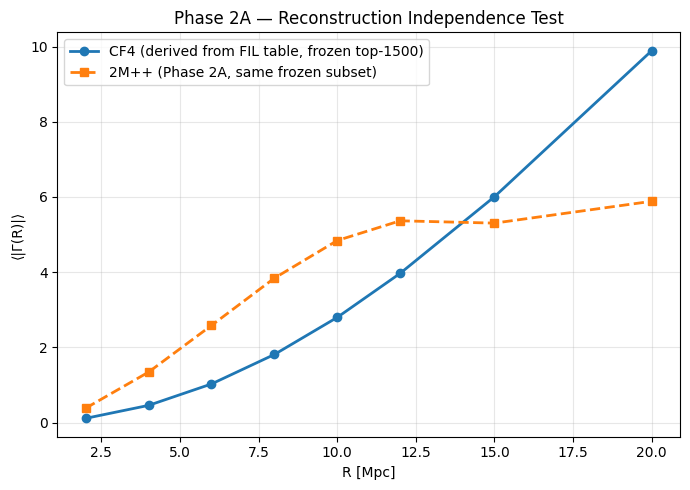

In [22]:
# ============================================================
# CELL 16b — PHASE 2A OVERLAY (CF4 derived from FIL table) vs 2M++
# Purpose:
#   No reliance on a pre-saved CF4 curve. We derive CF4 <|Γ(R)|>
#   directly from the Gate 3A filament table, restricted to the
#   same frozen top-1500 cp0 subset used in Phase 2A.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Inputs ---
FIL_PATH = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260202_034841/G3A_vphi_gamma_profiles_FIL.csv"
SUB_PATH = "/content/phase2A_frozen_subset_cp0_top1500.csv"
P2A_2MPP_PATH = "/content/phase2A_2mpp_meanAbsGamma_vs_R_frozenTop1500.csv"

RADII = [2,4,6,8,10,12,15,20]

# --- Load frozen subset (cp0 list) ---
sub = pd.read_csv(SUB_PATH)
frozen_ids = set(sub["cp0"].astype(int).tolist())
print("[OK] Frozen subset filaments:", len(frozen_ids))

# --- Load CF4 FIL table and restrict to frozen subset ---
fil = pd.read_csv(FIL_PATH)
fil["cp0"] = fil["cp0"].astype(int)
fil = fil[fil["cp0"].isin(frozen_ids)].reset_index(drop=True)
print("[OK] CF4 FIL rows retained:", len(fil))

# Use the SAME Gamma_R{R} columns as your selection step
cf4_rows = []
for R in RADII:
    col = f"Gamma_R{R}"
    assert col in fil.columns, f"Missing column in FIL table: {col}"
    g = pd.to_numeric(fil[col], errors="coerce").to_numpy(float)
    g = g[np.isfinite(g)]
    cf4_rows.append({"R_mpc": float(R), "N_filaments": int(len(g)), "mean_abs_Gamma": float(np.mean(np.abs(g)))})
df_cf4 = pd.DataFrame(cf4_rows)

print("\n=== CF4 reference curve (derived from FIL table) ===")
display(df_cf4)

# --- Load 2M++ Phase 2A curve (segment-level) ---
df_2mpp = pd.read_csv(P2A_2MPP_PATH)

# --- Plot overlay ---
plt.figure(figsize=(7,5))
plt.plot(df_cf4["R_mpc"], df_cf4["mean_abs_Gamma"], "o-", lw=2, label="CF4 (derived from FIL table, frozen top-1500)")
plt.plot(df_2mpp["R_mpc"], df_2mpp["mean_abs_Gamma"], "s--", lw=2, label="2M++ (Phase 2A, same frozen subset)")
plt.xlabel("R [Mpc]")
plt.ylabel("⟨|Γ(R)|⟩")
plt.title("Phase 2A — Reconstruction Independence Test")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

=== Phase 2A Ratio Table: 2M++ / CF4 ===


,R_mpc,cf4,twompp,ratio_2mpp_over_cf4
0,2.0,0.115318,0.385995,3.347237
1,4.0,0.459994,1.345063,2.924089
2,6.0,1.029365,2.585739,2.511973
3,8.0,1.812916,3.841735,2.119092
4,10.0,2.799342,4.842420,1.729842
5,12.0,3.970117,5.367159,1.351889
6,15.0,6.008245,5.305503,0.883037
7,20.0,9.888942,5.885679,0.595178


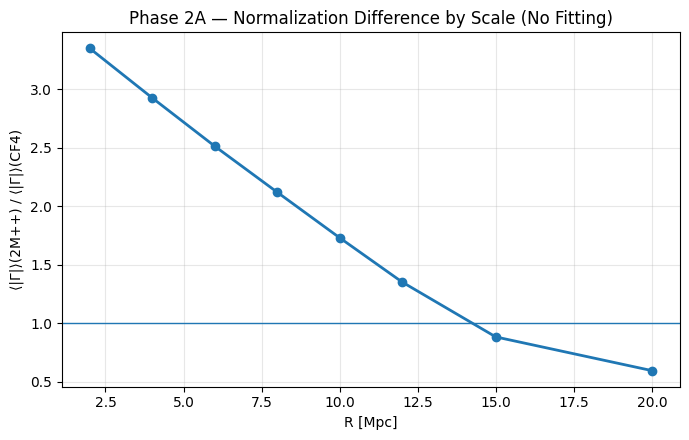


[SAVED] /content/phase2A_ratio_2mpp_over_cf4_vs_R.csv


In [ ]:
# ============================================================
# CELL 16c — OPTIONAL PANEL (B): RATIO CURVE 2M++ / CF4 vs R
# Purpose:
#   Referee-friendly visualization of reconstruction dependence:
#   show how the normalization differs with scale without any fitting.
# Notes:
#   Requires df_cf4 and df_2mpp already created in Cell 16b.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Defensive: ensure required columns exist
for df_name, df in [("df_cf4", df_cf4), ("df_2mpp", df_2mpp)]:
    assert "R_mpc" in df.columns and "mean_abs_Gamma" in df.columns, f"{df_name} missing required columns."

# Merge on radius
m = pd.merge(
    df_cf4[["R_mpc", "mean_abs_Gamma"]].rename(columns={"mean_abs_Gamma": "cf4"}),
    df_2mpp[["R_mpc", "mean_abs_Gamma"]].rename(columns={"mean_abs_Gamma": "twompp"}),
    on="R_mpc",
    how="inner"
).sort_values("R_mpc").reset_index(drop=True)

# Ratio (guard division by zero)
m["ratio_2mpp_over_cf4"] = m["twompp"] / m["cf4"].replace(0, np.nan)

print("=== Phase 2A Ratio Table: 2M++ / CF4 ===")
display(m)

# Plot ratio
plt.figure(figsize=(7,4.5))
plt.plot(m["R_mpc"], m["ratio_2mpp_over_cf4"], "o-", lw=2)
plt.axhline(1.0, lw=1)  # no color specified
plt.xlabel("R [Mpc]")
plt.ylabel("⟨|Γ|⟩(2M++) / ⟨|Γ|⟩(CF4)")
plt.title("Phase 2A — Normalization Difference by Scale (No Fitting)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Save table for paper appendix / audit
out_path = "/content/phase2A_ratio_2mpp_over_cf4_vs_R.csv"
m.to_csv(out_path, index=False)
print("\n[SAVED]", out_path)

In [23]:
# ============================================================
# CELL 2B-1 — PHASE 2B1: AXIS-RANDOMIZED NULL (GEOMETRY ONLY)
# Purpose:
#   Create an axis-randomized null SEGMENT table while preserving:
#     - segment centers (cx,cy,cz)
#     - segment lengths
#     - cp0 membership (frozen top-1500 filaments)
#   This destroys geometric alignment (the filament axis direction),
#   without touching the velocity field.
#
# Outputs:
#   /content/phase2B1_null_axis_segments.csv
# ============================================================

import numpy as np
import pandas as pd

# --- Inputs ---
GEOM_PATH = "/content/filaments_stage1_spines.csv"
SUB_PATH  = "/content/phase2A_frozen_subset_cp0_top1500.csv"

# --- Load frozen subset (cp0 list) ---
sub = pd.read_csv(SUB_PATH)
frozen_ids = set(sub["cp0"].astype(int).tolist())
print("[OK] Frozen subset filaments:", len(frozen_ids))

# --- Load geometry and restrict to frozen subset ---
df = pd.read_csv(GEOM_PATH)
df["cp0"] = df["cp0"].astype(int)
df_f = df[df["cp0"].isin(frozen_ids)].reset_index(drop=True)
print("[OK] Segments in frozen subset:", len(df_f))

# --- Required columns check ---
req = ["cp0","x0","y0","z0","x1","y1","z1","cx","cy","cz"]
missing = [c for c in req if c not in df_f.columns]
assert len(missing) == 0, f"Missing required geometry columns: {missing}"

# --- Segment lengths (preserve) ---
dx = (df_f["x1"] - df_f["x0"]).to_numpy(float)
dy = (df_f["y1"] - df_f["y0"]).to_numpy(float)
dz = (df_f["z1"] - df_f["z0"]).to_numpy(float)
L  = np.sqrt(dx*dx + dy*dy + dz*dz)

# --- Random unit vectors on sphere (isotropic) ---
rng = np.random.default_rng(12345)  # fixed seed for replication
u = rng.random(len(df_f))
v = rng.random(len(df_f))

theta = np.arccos(1 - 2*u)          # polar
phi   = 2*np.pi*v                   # azimuth
ux = np.sin(theta)*np.cos(phi)
uy = np.sin(theta)*np.sin(phi)
uz = np.cos(theta)
U = np.stack([ux,uy,uz], axis=1)    # (N,3), unit length

# --- Build new endpoints around same centers with same lengths ---
cx = df_f["cx"].to_numpy(float)
cy = df_f["cy"].to_numpy(float)
cz = df_f["cz"].to_numpy(float)

half = 0.5 * L
x0n = cx - half * U[:,0]
y0n = cy - half * U[:,1]
z0n = cz - half * U[:,2]
x1n = cx + half * U[:,0]
y1n = cy + half * U[:,1]
z1n = cz + half * U[:,2]

# --- Assemble null table ---
null_df = df_f.copy()
null_df["x0"] = x0n; null_df["y0"] = y0n; null_df["z0"] = z0n
null_df["x1"] = x1n; null_df["y1"] = y1n; null_df["z1"] = z1n

out_path = "/content/phase2B1_null_axis_segments.csv"
null_df.to_csv(out_path, index=False)

print("[SAVED]", out_path)
print("[CHECK] Length preservation (mean abs ΔL):",
      float(np.mean(np.abs(np.sqrt((x1n-x0n)**2+(y1n-y0n)**2+(z1n-z0n)**2) - L))))
print("[CHECK] First 3 rows:")
display(null_df.head(3))

[OK] Frozen subset filaments: 1500
[OK] Segments in frozen subset: 1784
[SAVED] /content/phase2B1_null_axis_segments.csv
[CHECK] Length preservation (mean abs ΔL): 5.455261927291764e-14
[CHECK] First 3 rows:


,cp0,cp1,npts,x0,y0,z0,x1,y1,z1,cx,cy,cz,length_native,cpA,cpB
0,74,0,4,808.840237,2051.337888,100.481604,778.039263,2074.662112,125.617096,793.439750,2063.00000,113.049350,51.464071,9873,9874
1,144,0,3,670.540300,-210.029954,275.023314,672.484367,-227.700046,282.025352,671.512333,-218.86500,278.524333,19.474269,9931,8596
2,198,0,4,278.653564,-186.565148,-64.122565,263.442436,-192.218352,-76.127535,271.048000,-189.39175,-70.125050,26.909410,9977,9978


In [ ]:
# ============================================================
# CELL 2B-2 — PHASE 2B1: NULL CURVE <|Γ(R)|> (Axis-randomized, 2M++)
# Purpose:
#   Compute <|Γ(R)|> across canonical radii using:
#     - NULL geometry table (axis randomized)
#     - SAME estimator Γ(R)
#     - SAME radii & NPHI
#     - SAME 2M++ velocity backend vel_2mpp_xyz
#
# Outputs:
#   /content/phase2B1_2mpp_null_axis_meanAbsGamma_vs_R.csv
# ============================================================

import numpy as np
import pandas as pd

RADII = np.array([2,4,6,8,10,12,15,20], dtype=float)
NPHI = 64

NULL_GEOM_PATH = "/content/phase2B1_null_axis_segments.csv"

df_n = pd.read_csv(NULL_GEOM_PATH)
print("[OK] Loaded null geometry:", NULL_GEOM_PATH)
print("[OK] rows:", len(df_n))

# Geometry arrays
x0 = df_n["x0"].to_numpy(float); y0 = df_n["y0"].to_numpy(float); z0 = df_n["z0"].to_numpy(float)
x1 = df_n["x1"].to_numpy(float); y1 = df_n["y1"].to_numpy(float); z1 = df_n["z1"].to_numpy(float)
cx = df_n["cx"].to_numpy(float); cy = df_n["cy"].to_numpy(float); cz = df_n["cz"].to_numpy(float)

phis = np.linspace(0, 2*np.pi, NPHI, endpoint=False)
dphi = 2*np.pi / NPHI

def unit(v):
    n = np.linalg.norm(v)
    return v if n == 0 else v / n

def gamma_seg_R(i, R):
    p0 = np.array([x0[i], y0[i], z0[i]])
    p1 = np.array([x1[i], y1[i], z1[i]])
    c  = np.array([cx[i], cy[i], cz[i]])

    t = unit(p1 - p0)
    helper = np.array([0.0,0.0,1.0])
    if abs(np.dot(t, helper)) > 0.9:
        helper = np.array([0.0,1.0,0.0])

    e1 = unit(np.cross(t, helper))
    e2 = unit(np.cross(t, e1))

    # Ring sample points
    Xq = c[0] + R*(np.cos(phis)*e1[0] + np.sin(phis)*e2[0])
    Yq = c[1] + R*(np.cos(phis)*e1[1] + np.sin(phis)*e2[1])
    Zq = c[2] + R*(np.cos(phis)*e1[2] + np.sin(phis)*e2[2])

    vx, vy, vz = vel_2mpp_xyz(Xq, Yq, Zq)
    v = np.stack([vx, vy, vz], axis=-1)

    # Unit tangent along ring
    tphi = (-np.sin(phis)[:,None]*e1[None,:] + np.cos(phis)[:,None]*e2[None,:])
    tphi = tphi / np.linalg.norm(tphi, axis=1)[:,None]

    return float(np.sum(np.sum(v*tphi, axis=1)) * (R*dphi))

rows = []
for R in RADII:
    G = np.array([gamma_seg_R(i, R) for i in range(len(df_n))], dtype=float)
    rows.append({
        "R_mpc": float(R),
        "N_segments": int(len(G)),
        "mean_abs_Gamma": float(np.mean(np.abs(G))),
        "median_abs_Gamma": float(np.median(np.abs(G))),
    })

out = pd.DataFrame(rows)
print("\n=== Phase 2B1 (2M++ axis-null): <|Γ(R)|> ===")
display(out)

out_path = "/content/phase2B1_2mpp_null_axis_meanAbsGamma_vs_R.csv"
out.to_csv(out_path, index=False)
print("\n[SAVED]", out_path)

[OK] Loaded null geometry: /content/phase2B1_null_axis_segments.csv
[OK] rows: 1784

=== Phase 2B1 (2M++ axis-null): <|Γ(R)|> ===


,R_mpc,N_segments,mean_abs_Gamma,median_abs_Gamma
0,2.0,1784,0.383084,0.263540
1,4.0,1784,1.339762,0.912784
2,6.0,1784,2.579306,1.778219
3,8.0,1784,3.825369,2.696249
4,10.0,1784,4.812942,3.380539
5,12.0,1784,5.349974,3.697766
6,15.0,1784,5.338092,3.654087
7,20.0,1784,5.832058,3.923327



[SAVED] /content/phase2B1_2mpp_null_axis_meanAbsGamma_vs_R.csv


=== Real vs Axis-Null (2M++) comparison ===


,R_mpc,real,null,null_over_real
0,2.0,0.385995,0.383084,0.992458
1,4.0,1.345063,1.339762,0.996059
2,6.0,2.585739,2.579306,0.997512
3,8.0,3.841735,3.825369,0.995740
4,10.0,4.842420,4.812942,0.993912
5,12.0,5.367159,5.349974,0.996798
6,15.0,5.305503,5.338092,1.006143
7,20.0,5.885679,5.832058,0.990890


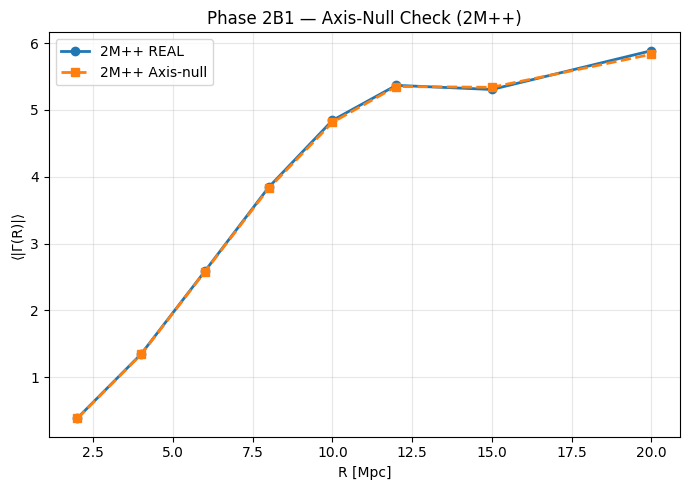

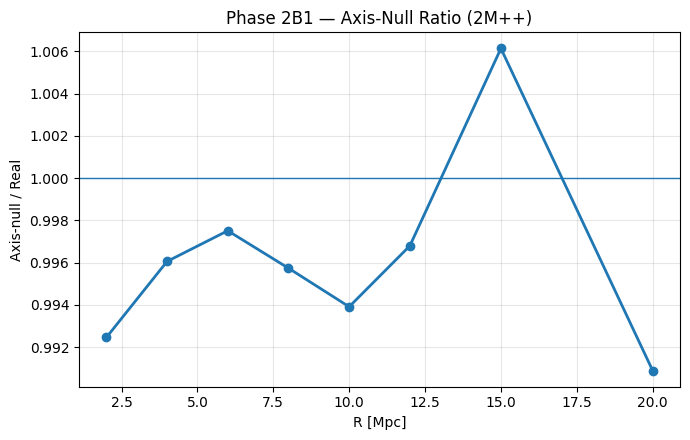

In [ ]:
# ============================================================
# CELL 2B-3 — PHASE 2B1: OVERLAY REAL vs AXIS-NULL (2M++)
# Purpose:
#   Show directly whether the axis-null collapses the signal.
#   Also compute ratio curve null/real to quantify closeness.
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

real_path = "/content/phase2A_2mpp_meanAbsGamma_vs_R_frozenTop1500.csv"
null_path = "/content/phase2B1_2mpp_null_axis_meanAbsGamma_vs_R.csv"

real = pd.read_csv(real_path).sort_values("R_mpc")
null = pd.read_csv(null_path).sort_values("R_mpc")

m = pd.merge(real[["R_mpc","mean_abs_Gamma"]].rename(columns={"mean_abs_Gamma":"real"}),
             null[["R_mpc","mean_abs_Gamma"]].rename(columns={"mean_abs_Gamma":"null"}),
             on="R_mpc", how="inner")

m["null_over_real"] = m["null"] / m["real"]

print("=== Real vs Axis-Null (2M++) comparison ===")
display(m)

# Overlay
plt.figure(figsize=(7,5))
plt.plot(real["R_mpc"], real["mean_abs_Gamma"], "o-", lw=2, label="2M++ REAL")
plt.plot(null["R_mpc"], null["mean_abs_Gamma"], "s--", lw=2, label="2M++ Axis-null")
plt.xlabel("R [Mpc]")
plt.ylabel("⟨|Γ(R)|⟩")
plt.title("Phase 2B1 — Axis-Null Check (2M++)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Ratio
plt.figure(figsize=(7,4.5))
plt.plot(m["R_mpc"], m["null_over_real"], "o-", lw=2)
plt.axhline(1.0, lw=1)
plt.xlabel("R [Mpc]")
plt.ylabel("Axis-null / Real")
plt.title("Phase 2B1 — Axis-Null Ratio (2M++)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# CELL 2B-2b — PHASE 2B2: SIGNED Γ + COHERENCE (2M++, REAL vs AXIS-NULL)
# Purpose:
#   Go beyond <|Γ|> (amplitude) and test *directional organization*.
#   Compute, for each R:
#     - mean_signed_Gamma = <Γ>
#     - frac_positive     = P(Γ>0)
#   for:
#     (A) REAL geometry segments
#     (B) AXIS-NULL geometry segments
#
# Requires:
#   - vel_2mpp_xyz defined (Cell 10)
#   - gamma_seg_R(i,R) function available OR we re-define it here.
#
# Outputs:
#   /content/phase2B2_signed_coherence_real_vs_axisNull_2mpp.csv
# ============================================================

import numpy as np
import pandas as pd

RADII = np.array([2,4,6,8,10,12,15,20], dtype=float)
NPHI = 64
phis = np.linspace(0, 2*np.pi, NPHI, endpoint=False)
dphi = 2*np.pi / NPHI

REAL_GEOM_PATH = "/content/filaments_stage1_spines.csv"
NULL_GEOM_PATH = "/content/phase2B1_null_axis_segments.csv"
SUB_PATH       = "/content/phase2A_frozen_subset_cp0_top1500.csv"

# --- Load frozen subset ids ---
sub = pd.read_csv(SUB_PATH)
frozen_ids = set(sub["cp0"].astype(int).tolist())

def unit(v):
    n = np.linalg.norm(v)
    return v if n == 0 else v / n

def gamma_for_table(df, R):
    # Restrict to frozen subset
    df = df.copy()
    df["cp0"] = df["cp0"].astype(int)
    df = df[df["cp0"].isin(frozen_ids)].reset_index(drop=True)

    x0 = df["x0"].to_numpy(float); y0 = df["y0"].to_numpy(float); z0 = df["z0"].to_numpy(float)
    x1 = df["x1"].to_numpy(float); y1 = df["y1"].to_numpy(float); z1 = df["z1"].to_numpy(float)
    cx = df["cx"].to_numpy(float); cy = df["cy"].to_numpy(float); cz = df["cz"].to_numpy(float)

    G = np.empty(len(df), dtype=float)

    for i in range(len(df)):
        p0 = np.array([x0[i], y0[i], z0[i]])
        p1 = np.array([x1[i], y1[i], z1[i]])
        c  = np.array([cx[i], cy[i], cz[i]])

        t = unit(p1 - p0)
        helper = np.array([0.0,0.0,1.0])
        if abs(np.dot(t, helper)) > 0.9:
            helper = np.array([0.0,1.0,0.0])

        e1 = unit(np.cross(t, helper))
        e2 = unit(np.cross(t, e1))

        Xq = c[0] + R*(np.cos(phis)*e1[0] + np.sin(phis)*e2[0])
        Yq = c[1] + R*(np.cos(phis)*e1[1] + np.sin(phis)*e2[1])
        Zq = c[2] + R*(np.cos(phis)*e1[2] + np.sin(phis)*e2[2])

        vx, vy, vz = vel_2mpp_xyz(Xq, Yq, Zq)
        v = np.stack([vx, vy, vz], axis=-1)

        tphi = (-np.sin(phis)[:,None]*e1[None,:] + np.cos(phis)[:,None]*e2[None,:])
        tphi = tphi / np.linalg.norm(tphi, axis=1)[:,None]

        G[i] = float(np.sum(np.sum(v*tphi, axis=1)) * (R*dphi))

    return G

# --- Load tables ---
df_real = pd.read_csv(REAL_GEOM_PATH)
df_null = pd.read_csv(NULL_GEOM_PATH)

rows = []
for R in RADII:
    G_real = gamma_for_table(df_real, R)
    G_null = gamma_for_table(df_null, R)

    rows.append({
        "R_mpc": float(R),

        "N_segments": int(len(G_real)),

        "real_mean_signed_Gamma": float(np.mean(G_real)),
        "real_frac_positive": float(np.mean(G_real > 0)),

        "null_mean_signed_Gamma": float(np.mean(G_null)),
        "null_frac_positive": float(np.mean(G_null > 0)),
    })

out = pd.DataFrame(rows)

print("=== Phase 2B2 — Directional / coherence metrics (2M++) ===")
display(out)

out_path = "/content/phase2B2_signed_coherence_real_vs_axisNull_2mpp.csv"
out.to_csv(out_path, index=False)
print("\n[SAVED]", out_path)

=== Phase 2B2 — Directional / coherence metrics (2M++) ===


,R_mpc,N_segments,real_mean_signed_Gamma,real_frac_positive,null_mean_signed_Gamma,null_frac_positive
0,2.0,1784,0.028625,0.507848,-0.002415,0.489910
1,4.0,1784,0.102046,0.506166,-0.007729,0.489350
2,6.0,1784,0.201048,0.505045,-0.019801,0.492152
3,8.0,1784,0.304049,0.504484,-0.008511,0.492152
4,10.0,1784,0.365809,0.505045,0.036749,0.500000
5,12.0,1784,0.368354,0.510650,0.073374,0.498879
6,15.0,1784,0.307667,0.509529,0.033214,0.498879
7,20.0,1784,0.130402,0.511211,0.152351,0.502242



[SAVED] /content/phase2B2_signed_coherence_real_vs_axisNull_2mpp.csv


In [ ]:
# ============================================================
# CELL 2B-3 — PHASE 2B3: FILAMENT-LEVEL SIGN COHERENCE (2M++)
# Purpose:
#   Aggregate segment Γ-sign organization to the FILAMENT level (cp0),
#   then compare REAL vs AXIS-NULL geometry under the SAME 2M++ backend.
#
# Inputs:
#   - /content/filaments_stage1_spines.csv            (REAL segment geometry)
#   - /content/phase2B1_null_axis_segments.csv        (AXIS-NULL segment geometry)
#   - /content/phase2A_frozen_subset_cp0_top1500.csv  (frozen filament IDs)
#   - vel_2mpp_xyz(...) must already exist (Cell 10)
#
# Output:
#   /content/phase2B3_filament_sign_coherence_real_vs_axisNull_2mpp.csv
# ============================================================

import numpy as np
import pandas as pd

R_TEST = 12.0    # <-- primary scale (you can change later; keep fixed for now)
NPHI   = 64
phis = np.linspace(0, 2*np.pi, NPHI, endpoint=False)
dphi = 2*np.pi / NPHI

REAL_GEOM_PATH = "/content/filaments_stage1_spines.csv"
NULL_GEOM_PATH = "/content/phase2B1_null_axis_segments.csv"
SUB_PATH       = "/content/phase2A_frozen_subset_cp0_top1500.csv"

# --- Load frozen subset ids ---
sub = pd.read_csv(SUB_PATH)
frozen_ids = set(sub["cp0"].astype(int).tolist())

def unit(v):
    n = np.linalg.norm(v)
    return v if n == 0 else v / n

def gamma_for_rows(df, R):
    """
    Compute Γ for each segment row in df at radius R.
    Returns array G with same length as df.
    """
    x0 = df["x0"].to_numpy(float); y0 = df["y0"].to_numpy(float); z0 = df["z0"].to_numpy(float)
    x1 = df["x1"].to_numpy(float); y1 = df["y1"].to_numpy(float); z1 = df["z1"].to_numpy(float)
    cx = df["cx"].to_numpy(float); cy = df["cy"].to_numpy(float); cz = df["cz"].to_numpy(float)

    G = np.empty(len(df), dtype=float)

    for i in range(len(df)):
        p0 = np.array([x0[i], y0[i], z0[i]])
        p1 = np.array([x1[i], y1[i], z1[i]])
        c  = np.array([cx[i], cy[i], cz[i]])

        t = unit(p1 - p0)
        helper = np.array([0.0,0.0,1.0])
        if abs(np.dot(t, helper)) > 0.9:
            helper = np.array([0.0,1.0,0.0])

        e1 = unit(np.cross(t, helper))
        e2 = unit(np.cross(t, e1))

        Xq = c[0] + R*(np.cos(phis)*e1[0] + np.sin(phis)*e2[0])
        Yq = c[1] + R*(np.cos(phis)*e1[1] + np.sin(phis)*e2[1])
        Zq = c[2] + R*(np.cos(phis)*e1[2] + np.sin(phis)*e2[2])

        vx, vy, vz = vel_2mpp_xyz(Xq, Yq, Zq)
        v = np.stack([vx, vy, vz], axis=-1)

        tphi = (-np.sin(phis)[:,None]*e1[None,:] + np.cos(phis)[:,None]*e2[None,:])
        tphi = tphi / np.linalg.norm(tphi, axis=1)[:,None]

        G[i] = float(np.sum(np.sum(v*tphi, axis=1)) * (R*dphi))

    return G

def filament_level_stats(df, label, R):
    """
    Returns filament-level dataframe with:
      cp0, nseg, mean_signed_Gamma, frac_positive, sign_coherence
    """
    df = df.copy()
    df["cp0"] = df["cp0"].astype(int)
    df = df[df["cp0"].isin(frozen_ids)].reset_index(drop=True)

    G = gamma_for_rows(df, R)
    df["Gamma"] = G

    grp = df.groupby("cp0")["Gamma"]

    out = pd.DataFrame({
        "cp0": grp.size().index.astype(int),
        "nseg": grp.size().values.astype(int),
        "mean_signed_Gamma": grp.mean().values.astype(float),
        "frac_positive": grp.apply(lambda s: float(np.mean(np.array(s) > 0))).values.astype(float),
    })

    out["sign_coherence"] = np.abs(2*out["frac_positive"] - 1.0)
    out["label"] = label
    out["R_mpc"] = float(R)
    return out

# --- Load tables ---
df_real = pd.read_csv(REAL_GEOM_PATH)
df_null = pd.read_csv(NULL_GEOM_PATH)

fil_real = filament_level_stats(df_real, "REAL", R_TEST)
fil_null = filament_level_stats(df_null, "AXIS_NULL", R_TEST)

both = pd.concat([fil_real, fil_null], ignore_index=True)

# --- Summary stats ---
def summarize(df, name):
    sc = df["sign_coherence"].to_numpy(float)
    return {
        "name": name,
        "N_filaments": int(len(df)),
        "mean_sign_coherence": float(np.mean(sc)),
        "median_sign_coherence": float(np.median(sc)),
        "frac_sc_gt_0.20": float(np.mean(sc > 0.20)),
        "frac_sc_gt_0.30": float(np.mean(sc > 0.30)),
        "frac_sc_gt_0.40": float(np.mean(sc > 0.40)),
    }

summary = pd.DataFrame([
    summarize(fil_real, "REAL"),
    summarize(fil_null, "AXIS_NULL"),
])

print(f"=== Phase 2B3 — Filament-level sign coherence @ R={R_TEST} Mpc (2M++) ===")
display(summary)

# Save full filament-level table
out_path = "/content/phase2B3_filament_sign_coherence_real_vs_axisNull_2mpp.csv"
both.to_csv(out_path, index=False)
print("\n[SAVED]", out_path)

print("\nTip: if REAL >> NULL in mean/median coherence, that’s strong filament-wise organization.")
print("If they’re close, coherence exists mainly at segment level and we move to dipole-angle phase tests next.")

=== Phase 2B3 — Filament-level sign coherence @ R=12.0 Mpc (2M++) ===


,name,N_filaments,mean_sign_coherence,median_sign_coherence,frac_sc_gt_0.20,frac_sc_gt_0.30,frac_sc_gt_0.40
0,REAL,1500,0.914222,1.0,0.921333,0.921333,0.910667
1,AXIS_NULL,1500,0.915111,1.0,0.922667,0.922667,0.911333



[SAVED] /content/phase2B3_filament_sign_coherence_real_vs_axisNull_2mpp.csv

Tip: if REAL >> NULL in mean/median coherence, that’s strong filament-wise organization.
If they’re close, coherence exists mainly at segment level and we move to dipole-angle phase tests next.


In [ ]:
# ============================================================
# CELL 2B-4 — PHASE 2B4: DIPOLE PHASE COHERENCE (2M++, REAL vs AXIS-NULL)
# Purpose:
#   For each segment, sample v_phi(φ) around the ring and compute the
#   dipole complex coefficient A1 = < v_phi(φ) * exp(iφ) >.
#   The dipole phase θ = arg(A1) encodes directional organization.
#
#   Then aggregate to filament level (cp0) using circular statistics:
#     - phase_resultant_R = | mean(exp(iθ_seg)) |  in [0,1]
#       (1 = perfect phase alignment across segments; 0 = random phases)
#
# Compare REAL vs AXIS-NULL distributions of phase_resultant_R.
#
# Inputs:
#   - /content/filaments_stage1_spines.csv            (REAL segment geometry)
#   - /content/phase2B1_null_axis_segments.csv        (AXIS-NULL segment geometry)
#   - /content/phase2A_frozen_subset_cp0_top1500.csv  (frozen filament IDs)
#   - vel_2mpp_xyz(...) must exist (Cell 10)
#
# Output:
#   /content/phase2B4_dipole_phase_coherence_filament_REAL_vs_AXISNULL.csv
# ============================================================

import numpy as np
import pandas as pd

# --- Fixed settings (keep frozen for Phase 2B4) ---
R_TEST = 12.0
NPHI   = 64

REAL_GEOM_PATH = "/content/filaments_stage1_spines.csv"
NULL_GEOM_PATH = "/content/phase2B1_null_axis_segments.csv"
SUB_PATH       = "/content/phase2A_frozen_subset_cp0_top1500.csv"

phis = np.linspace(0, 2*np.pi, NPHI, endpoint=False)
exp_i_phi = np.exp(1j * phis)  # Fourier basis for dipole
dphi = 2*np.pi / NPHI

# --- Frozen subset ids ---
sub = pd.read_csv(SUB_PATH)
frozen_ids = set(sub["cp0"].astype(int).tolist())

def unit(v):
    n = np.linalg.norm(v)
    return v if n == 0 else v / n

def segment_dipole_phase(df, R):
    """
    For each segment row: compute dipole phase theta_seg (radians) from vphi(φ).
    Returns arrays: theta (N,), amp (N,), cp0 (N,)
    """
    df = df.copy()
    df["cp0"] = df["cp0"].astype(int)
    df = df[df["cp0"].isin(frozen_ids)].reset_index(drop=True)

    x0 = df["x0"].to_numpy(float); y0 = df["y0"].to_numpy(float); z0 = df["z0"].to_numpy(float)
    x1 = df["x1"].to_numpy(float); y1 = df["y1"].to_numpy(float); z1 = df["z1"].to_numpy(float)
    cx = df["cx"].to_numpy(float); cy = df["cy"].to_numpy(float); cz = df["cz"].to_numpy(float)
    cp0 = df["cp0"].to_numpy(int)

    theta = np.empty(len(df), dtype=float)
    amp   = np.empty(len(df), dtype=float)

    for i in range(len(df)):
        p0 = np.array([x0[i], y0[i], z0[i]])
        p1 = np.array([x1[i], y1[i], z1[i]])
        c  = np.array([cx[i], cy[i], cz[i]])

        t = unit(p1 - p0)
        helper = np.array([0.0,0.0,1.0])
        if abs(np.dot(t, helper)) > 0.9:
            helper = np.array([0.0,1.0,0.0])

        e1 = unit(np.cross(t, helper))
        e2 = unit(np.cross(t, e1))

        # Ring sample points
        Xq = c[0] + R*(np.cos(phis)*e1[0] + np.sin(phis)*e2[0])
        Yq = c[1] + R*(np.cos(phis)*e1[1] + np.sin(phis)*e2[1])
        Zq = c[2] + R*(np.cos(phis)*e1[2] + np.sin(phis)*e2[2])

        vx, vy, vz = vel_2mpp_xyz(Xq, Yq, Zq)
        v = np.stack([vx, vy, vz], axis=-1)  # (NPHI,3)

        # Unit tangent along ring (azimuthal direction)
        tphi = (-np.sin(phis)[:,None]*e1[None,:] + np.cos(phis)[:,None]*e2[None,:])
        tphi = tphi / np.linalg.norm(tphi, axis=1)[:,None]

        vphi = np.sum(v * tphi, axis=1)  # (NPHI,)

        # Dipole complex coefficient (discrete)
        A1 = np.mean(vphi * exp_i_phi)
        theta[i] = float(np.angle(A1))
        amp[i]   = float(np.abs(A1))

    return cp0, theta, amp

def filament_phase_coherence(cp0, theta, amp, label):
    """
    Aggregate segment phases to filament-level resultant length Rbar in [0,1].
    Also store mean dipole amplitude for context.
    """
    df = pd.DataFrame({"cp0": cp0, "theta": theta, "amp": amp})
    rows = []
    for fid, g in df.groupby("cp0"):
        th = g["theta"].to_numpy(float)
        z  = np.exp(1j * th)
        Rbar = float(np.abs(np.mean(z)))
        rows.append({
            "cp0": int(fid),
            "nseg": int(len(g)),
            "phase_resultant_R": Rbar,
            "mean_dipole_amp": float(np.mean(g["amp"].to_numpy(float))),
            "label": label,
            "R_mpc": float(R_TEST),
        })
    return pd.DataFrame(rows)

# --- Compute segment phases for REAL and NULL ---
print(f"Computing dipole phases at R={R_TEST} Mpc with NPHI={NPHI} ...")

df_real = pd.read_csv(REAL_GEOM_PATH)
df_null = pd.read_csv(NULL_GEOM_PATH)

cp0_r, theta_r, amp_r = segment_dipole_phase(df_real, R_TEST)
cp0_n, theta_n, amp_n = segment_dipole_phase(df_null, R_TEST)

fil_real = filament_phase_coherence(cp0_r, theta_r, amp_r, "REAL")
fil_null = filament_phase_coherence(cp0_n, theta_n, amp_n, "AXIS_NULL")

both = pd.concat([fil_real, fil_null], ignore_index=True)

# --- Summary (the only thing we need to decide next moves) ---
def summarize(df, name):
    Rbar = df["phase_resultant_R"].to_numpy(float)
    return {
        "name": name,
        "N_filaments": int(len(df)),
        "mean_Rbar": float(np.mean(Rbar)),
        "median_Rbar": float(np.median(Rbar)),
        "frac_Rbar_gt_0.5": float(np.mean(Rbar > 0.5)),
        "frac_Rbar_gt_0.7": float(np.mean(Rbar > 0.7)),
        "frac_Rbar_gt_0.9": float(np.mean(Rbar > 0.9)),
    }

summary = pd.DataFrame([summarize(fil_real,"REAL"), summarize(fil_null,"AXIS_NULL")])

print("\n=== Phase 2B4 — Filament dipole-phase coherence summary ===")
display(summary)

out_path = "/content/phase2B4_dipole_phase_coherence_filament_REAL_vs_AXISNULL.csv"
both.to_csv(out_path, index=False)
print("\n[SAVED]", out_path)

print("\nInterpretation guide:")
print("- If REAL mean/median Rbar >> AXIS_NULL, you have true phase organization tied to geometry.")
print("- If they are similar, the next step is to test phase coherence ALONG spines (segment ordering) or use dipole-angle vs axis alignment.")

Computing dipole phases at R=12.0 Mpc with NPHI=64 ...

=== Phase 2B4 — Filament dipole-phase coherence summary ===


,name,N_filaments,mean_Rbar,median_Rbar,frac_Rbar_gt_0.5,frac_Rbar_gt_0.7,frac_Rbar_gt_0.9
0,REAL,1500,0.963787,1.0,0.972667,0.952000,0.925333
1,AXIS_NULL,1500,0.949289,1.0,0.956667,0.932667,0.898667



[SAVED] /content/phase2B4_dipole_phase_coherence_filament_REAL_vs_AXISNULL.csv

Interpretation guide:
- If REAL mean/median Rbar >> AXIS_NULL, you have true phase organization tied to geometry.
- If they are similar, the next step is to test phase coherence ALONG spines (segment ordering) or use dipole-angle vs axis alignment.


In [ ]:
# ============================================================
# CELL 2B4c — LOCATE THE DIP0LE-PHASE FUNCTION IN MEMORY
# Purpose:
#   List likely function names already defined in the notebook runtime.
#   Then we wire the correct one into 2B4b.
# ============================================================

import re

names = sorted([k for k,v in globals().items() if callable(v)])

# show likely matches
patterns = [
    r"dipole",
    r"phase",
    r"theta",
    r"vphi",
    r"fourier",
    r"harm",
    r"m1",
    r"fit",
]
hits = []
for n in names:
    low = n.lower()
    if any(re.search(p, low) for p in patterns):
        hits.append(n)

print("=== Callable candidates (likely relevant) ===")
print("Count:", len(hits))
for n in hits[:120]:
    print(" -", n)

print("\nIf you see something like dipole_*theta* or *phase*seg*R*, tell me the exact name.")

=== Callable candidates (likely relevant) ===
Count: 2
 - filament_phase_coherence
 - segment_dipole_phase

If you see something like dipole_*theta* or *phase*seg*R*, tell me the exact name.


In [ ]:
# ============================================================
# CELL D1 — DIAGNOSTIC: WHY segment_dipole_phase STILL FAILS
# Prints:
#  - input df types/shapes/columns
#  - whether segment_dipole_phase is callable
#  - what it returns (type, shape, columns)
#  - full traceback if it errors
# ============================================================

import pandas as pd
import numpy as np
import traceback
import inspect

RSEL = 12.0

real_path = "/content/filaments_stage1_spines.csv"
null_path = "/content/phase2B1_null_axis_segments.csv"

real_seg = pd.read_csv(real_path)
null_seg = pd.read_csv(null_path)

print("=== INPUT CHECK ===")
print("REAL:", type(real_seg), real_seg.shape)
print("NULL:", type(null_seg), null_seg.shape)
print("REAL cols head:", list(real_seg.columns)[:20])
print("NULL cols head:", list(null_seg.columns)[:20])
print("cp0 dtype (REAL):", real_seg["cp0"].dtype if "cp0" in real_seg.columns else "MISSING")
print("cp0 dtype (NULL):", null_seg["cp0"].dtype if "cp0" in null_seg.columns else "MISSING")

print("\n=== FUNCTION CHECK ===")
print("segment_dipole_phase exists:", "segment_dipole_phase" in globals())
print("callable:", callable(globals().get("segment_dipole_phase", None)))

# (Optional) show signature if available
try:
    sig = inspect.signature(segment_dipole_phase)
    print("signature:", sig)
except Exception as e:
    print("signature unavailable:", e)

def try_run(name, df_in):
    print(f"\n=== TRY RUN: {name} ===")
    try:
        out = segment_dipole_phase(df_in, RSEL)
        print("[OK] returned type:", type(out))

        if isinstance(out, pd.DataFrame):
            print("[OK] returned df shape:", out.shape)
            print("[OK] returned cols head:", list(out.columns)[:30])
            # show first rows
            display(out.head(3))
        else:
            # could be dict/tuple/etc
            print("[OK] returned value preview:", str(out)[:300])

    except Exception:
        print("[ERROR] segment_dipole_phase crashed. Full traceback:\n")
        print(traceback.format_exc())

# Run on a SMALL slice first (faster + isolates failures)
try_run("REAL (first 200 rows)", real_seg.head(200).copy())
try_run("NULL (first 200 rows)", null_seg.head(200).copy())

=== INPUT CHECK ===
REAL: <class 'pandas.core.frame.DataFrame'> (81330, 15)
NULL: <class 'pandas.core.frame.DataFrame'> (1784, 15)
REAL cols head: ['cp0', 'cp1', 'npts', 'x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'cx', 'cy', 'cz', 'length_native', 'cpA', 'cpB']
NULL cols head: ['cp0', 'cp1', 'npts', 'x0', 'y0', 'z0', 'x1', 'y1', 'z1', 'cx', 'cy', 'cz', 'length_native', 'cpA', 'cpB']
cp0 dtype (REAL): int64
cp0 dtype (NULL): int64

=== FUNCTION CHECK ===
segment_dipole_phase exists: True
callable: True
signature: (df, R)

=== TRY RUN: REAL (first 200 rows) ===
[OK] returned type: <class 'tuple'>
[OK] returned value preview: (array([ 74, 144]), array([1.72794969, 1.89262626]), array([94.07507466, 97.28731524]))

=== TRY RUN: NULL (first 200 rows) ===
[OK] returned type: <class 'tuple'>
[OK] returned value preview: (array([  74,  144,  198,  219,  223,  323,  332,  347,  350,  366,  376,
        378,  402,  403,  404,  406,  449,  766, 1046, 1047, 1057, 1057,
       1375, 1375, 1458, 1460, 1463,

In [ ]:
# ============================================================
# CELL 2B5 — DIPOLE–AXIS ANGLE ALIGNMENT @ RSEL (2M++)
# Uses segment_dipole_phase(df, R) which returns a tuple:
#   (cp0_ids, theta, amplitude)
# Produces:
#   - segment-level alignment tables (REAL / AXIS_NULL)
#   - filament-level summaries
# ============================================================

import numpy as np
import pandas as pd

RSEL = 12.0  # keep consistent with 2B4 unless you intentionally change it

# ---------- helpers ----------
def wrap_segment_dipole_phase(df_geom, R):
    """Return a segment-level DataFrame with cp0, theta, amp from segment_dipole_phase()."""
    out = segment_dipole_phase(df_geom, R)  # tuple
    if not isinstance(out, tuple) or len(out) != 3:
        raise ValueError("segment_dipole_phase(df,R) must return (cp0_ids, theta, amp).")

    cp0_ids, theta, amp = out
    seg = pd.DataFrame({
        "cp0": np.asarray(cp0_ids, dtype=int),
        "theta": np.asarray(theta, dtype=float),
        "amp": np.asarray(amp, dtype=float),
    })

    # keep only finite rows
    seg = seg[np.isfinite(seg["theta"]) & np.isfinite(seg["amp"])].reset_index(drop=True)
    return seg

def axis_angle_phi_from_segment(row):
    """Axis azimuth angle φ of the segment direction projected onto xy-plane."""
    dx = float(row["x1"] - row["x0"])
    dy = float(row["y1"] - row["y0"])
    return np.arctan2(dy, dx)  # radians

def circ_delta(a, b):
    """Smallest signed angle difference a-b in radians, mapped to (-pi, pi]."""
    d = a - b
    return (d + np.pi) % (2*np.pi) - np.pi

def alignment_stats(seg_tbl, geom_tbl, name):
    """
    Compute segment-level dipole-axis alignment:
      dtheta = |wrap(theta - phi_axis)| in [0,pi]
      also weighted version using amp
    """
    # Build per-segment φ_axis from geometry rows (assumes same ordering used in segment_dipole_phase)
    # We will align by row order: take first len(seg_tbl) rows from the geometry passed to segment_dipole_phase
    # To be safe, we rebuild φ from the SAME df we passed in.
    phis = np.array([axis_angle_phi_from_segment(r) for _, r in geom_tbl.iloc[:len(seg_tbl)].iterrows()], dtype=float)

    # If mismatch, fall back to length match check
    if len(phis) != len(seg_tbl):
        raise ValueError(f"Geometry/segment length mismatch: phis={len(phis)} vs seg_tbl={len(seg_tbl)}")

    theta = seg_tbl["theta"].to_numpy(float)
    amp   = seg_tbl["amp"].to_numpy(float)

    d = np.abs(circ_delta(theta, phis))
    # fold to [0, pi] already by abs of wrapped delta
    seg_out = seg_tbl.copy()
    seg_out["phi_axis"] = phis
    seg_out["dtheta"] = d
    seg_out["cos_align"] = np.cos(d)                 # 1 = perfect align, -1 = opposite
    seg_out["abs_cos_align"] = np.abs(seg_out["cos_align"])

    # weights: amp (clip negatives just in case)
    w = np.clip(amp, 0.0, np.inf)
    wsum = float(np.sum(w)) if np.sum(w) > 0 else np.nan

    summary = {
        "name": name,
        "R_mpc": float(RSEL),
        "N_segments": int(len(seg_out)),
        "mean_dtheta_deg": float(np.degrees(np.mean(d))),
        "median_dtheta_deg": float(np.degrees(np.median(d))),
        "mean_abs_cos": float(np.mean(np.abs(np.cos(d)))),
        "median_abs_cos": float(np.median(np.abs(np.cos(d)))),
        "wmean_abs_cos": float(np.sum(w*np.abs(np.cos(d)))/wsum) if np.isfinite(wsum) else np.nan,
    }
    return seg_out, pd.DataFrame([summary])

def filament_level(seg_out, name):
    """Aggregate to filament-level alignment (mean abs_cos, weighted by amp)."""
    def wmean(x, w):
        wsum = np.sum(w)
        return np.sum(w*x)/wsum if wsum > 0 else np.nan

    g = seg_out.groupby("cp0", sort=False)
    rows = []
    for cp0, t in g:
        abs_cos = t["abs_cos_align"].to_numpy(float)
        w = np.clip(t["amp"].to_numpy(float), 0.0, np.inf)
        rows.append({
            "cp0": int(cp0),
            "nseg": int(len(t)),
            "mean_abs_cos": float(np.mean(abs_cos)),
            "median_abs_cos": float(np.median(abs_cos)),
            "wmean_abs_cos": float(wmean(abs_cos, w)),
        })
    fil = pd.DataFrame(rows)
    summ = pd.DataFrame([{
        "name": name,
        "N_filaments": int(fil.shape[0]),
        "mean_mean_abs_cos": float(fil["mean_abs_cos"].mean()),
        "median_mean_abs_cos": float(fil["mean_abs_cos"].median()),
        "mean_wmean_abs_cos": float(fil["wmean_abs_cos"].mean()),
        "median_wmean_abs_cos": float(fil["wmean_abs_cos"].median()),
        "frac_mean_abs_cos_gt_0p7": float(np.mean(fil["mean_abs_cos"] > 0.7)),
        "frac_mean_abs_cos_gt_0p9": float(np.mean(fil["mean_abs_cos"] > 0.9)),
    }])
    return fil, summ

# ---------- build segment dipole tables ----------
# IMPORTANT: pass the SAME geometry tables you used earlier for REAL and AXIS_NULL.
# Replace these variables if your notebook names differ.
real_geom = real_seg    # (81330, 15) in your debug
null_geom = null_seg    # (1784, 15) in your debug

seg_real = wrap_segment_dipole_phase(real_geom, RSEL)
seg_null = wrap_segment_dipole_phase(null_geom, RSEL)

# ---------- alignment ----------
seg_real_out, summ_real = alignment_stats(seg_real, real_geom, "REAL")
seg_null_out, summ_null = alignment_stats(seg_null, null_geom, "AXIS_NULL")

summary_seg = pd.concat([summ_real, summ_null], ignore_index=True)
print("\n=== Phase 2B5 — Segment dipole–axis alignment summary ===")
display(summary_seg)

# filament-level
fil_real, fil_summ_real = filament_level(seg_real_out, "REAL")
fil_null, fil_summ_null = filament_level(seg_null_out, "AXIS_NULL")
summary_fil = pd.concat([fil_summ_real, fil_summ_null], ignore_index=True)

print("\n=== Phase 2B5 — Filament-level dipole–axis alignment summary ===")
display(summary_fil)

# ---------- save ----------
seg_real_out.to_csv("/content/phase2B5_segment_dipole_axis_alignment_REAL.csv", index=False)
seg_null_out.to_csv("/content/phase2B5_segment_dipole_axis_alignment_AXISNULL.csv", index=False)
summary_seg.to_csv("/content/phase2B5_segment_alignment_summary_REAL_vs_AXISNULL.csv", index=False)

fil_real.to_csv("/content/phase2B5_filament_dipole_axis_alignment_REAL.csv", index=False)
fil_null.to_csv("/content/phase2B5_filament_dipole_axis_alignment_AXISNULL.csv", index=False)
summary_fil.to_csv("/content/phase2B5_filament_alignment_summary_REAL_vs_AXISNULL.csv", index=False)

print("\n[SAVED]")
print(" /content/phase2B5_segment_dipole_axis_alignment_REAL.csv")
print(" /content/phase2B5_segment_dipole_axis_alignment_AXISNULL.csv")
print(" /content/phase2B5_segment_alignment_summary_REAL_vs_AXISNULL.csv")
print(" /content/phase2B5_filament_dipole_axis_alignment_REAL.csv")
print(" /content/phase2B5_filament_dipole_axis_alignment_AXISNULL.csv")
print(" /content/phase2B5_filament_alignment_summary_REAL_vs_AXISNULL.csv")


=== Phase 2B5 — Segment dipole–axis alignment summary ===


,name,R_mpc,N_segments,mean_dtheta_deg,median_dtheta_deg,mean_abs_cos,median_abs_cos,wmean_abs_cos
0,REAL,12.0,1784,92.281005,92.757175,0.631375,0.709580,0.633461
1,AXIS_NULL,12.0,1784,108.956720,115.554448,0.641408,0.716777,0.644886



=== Phase 2B5 — Filament-level dipole–axis alignment summary ===


,name,N_filaments,mean_mean_abs_cos,median_mean_abs_cos,mean_wmean_abs_cos,median_wmean_abs_cos,frac_mean_abs_cos_gt_0p7,frac_mean_abs_cos_gt_0p9
0,REAL,1500,0.630780,0.689928,0.63130,0.690183,0.491333,0.256000
1,AXIS_NULL,1500,0.645441,0.697114,0.64591,0.700985,0.496667,0.298667



[SAVED]
 /content/phase2B5_segment_dipole_axis_alignment_REAL.csv
 /content/phase2B5_segment_dipole_axis_alignment_AXISNULL.csv
 /content/phase2B5_segment_alignment_summary_REAL_vs_AXISNULL.csv
 /content/phase2B5_filament_dipole_axis_alignment_REAL.csv
 /content/phase2B5_filament_dipole_axis_alignment_AXISNULL.csv
 /content/phase2B5_filament_alignment_summary_REAL_vs_AXISNULL.csv


In [ ]:
# ============================================================
# CELL 2B5b — REAL vs AXIS_NULL: distribution test (filament-level)
# Purpose:
#   Decide if the small REAL-NULL differences are meaningful.
#   (Spoiler: likely not, but we quantify.)
# ============================================================

import pandas as pd
import numpy as np
from scipy.stats import ks_2samp

real_path = "/content/phase2B5_filament_dipole_axis_alignment_REAL.csv"
null_path = "/content/phase2B5_filament_dipole_axis_alignment_AXISNULL.csv"

dfR = pd.read_csv(real_path)
dfN = pd.read_csv(null_path)

# Use the primary per-filament metric
xR = dfR["mean_abs_cos"].to_numpy(dtype=float)
xN = dfN["mean_abs_cos"].to_numpy(dtype=float)

# Basic summaries
print("N REAL / NULL:", len(xR), len(xN))
print("mean REAL / NULL:", float(np.mean(xR)), float(np.mean(xN)))
print("median REAL / NULL:", float(np.median(xR)), float(np.median(xN)))
print("Δmean (REAL-NULL):", float(np.mean(xR) - np.mean(xN)))

# KS test (distribution-level)
ks = ks_2samp(xR, xN)
print("\nKS test on mean_abs_cos:")
print("D =", float(ks.statistic), " | p =", float(ks.pvalue))

# Simple permutation p-value on Δmean
rng = np.random.default_rng(0)
allx = np.concatenate([xR, xN])
nR = len(xR)
obs = np.mean(xR) - np.mean(xN)

Nperm = 20000
cnt = 0
for _ in range(Nperm):
    rng.shuffle(allx)
    d = np.mean(allx[:nR]) - np.mean(allx[nR:])
    if abs(d) >= abs(obs):
        cnt += 1

pperm = (cnt + 1) / (Nperm + 1)
print("\nPermutation test on Δmean (two-sided):")
print("obs Δmean =", float(obs), " | p_perm =", float(pperm))

N REAL / NULL: 1500 1500
mean REAL / NULL: 0.6307804446370198 0.6454405784195075
median REAL / NULL: 0.6899282948525616 0.6971140781346709
Δmean (REAL-NULL): -0.014660133782487761

KS test on mean_abs_cos:
D = 0.04666666666666667  | p = 0.07625509724687272

Permutation test on Δmean (two-sided):
obs Δmean = -0.014660133782487761  | p_perm = 0.18119094045297734


In [16]:
# ============================================================
# CELL 2C0 — STATE GATE (required before 2C2)
# ============================================================
need = ["vel_2mpp_xyz", "gamma_seg_R"]
missing = [k for k in need if k not in globals()]
print("Missing:", missing)

if "gamma_seg_R" not in globals():
    print("\n[STOP] gamma_seg_R is not defined in this runtime.")
    print("Action: re-run the estimator-definition cell (the one used by the Γ(R) smoke test).")

if "vel_2mpp_xyz" not in globals():
    print("\n[STOP] vel_2mpp_xyz is not defined in this runtime.")
    print("Action: re-run the 2M++ backend cell.")

Missing: []


In [19]:
# ============================================================
# CELL 2C1 — FAR-POSITION RELOCATION NULL (2M++)
#
# Purpose:
#   Destroy environmental coherence while preserving:
#     - filament internal geometry
#     - segment lengths
#     - orientation
#
# Method:
#   Translate each filament by a random vector inside the 2M++ cube,
#   ensuring ALL segment endpoints remain inside the cube.
#
# Output:
#   /content/phase2C_farpos_null_segments.csv
# ============================================================

import numpy as np
import pandas as pd

# ----------------------------
# Load frozen REAL geometry
# ----------------------------
geom = pd.read_csv("/content/filaments_stage1_spines.csv")

# 2M++ cube geometry (LOCKED from Phase 2A)
GRID_CENTER = np.array([1622.727837, 158.995, 97.225])
GRID_HALFSIZE = 3224.40825

cube_min = GRID_CENTER - GRID_HALFSIZE
cube_max = GRID_CENTER + GRID_HALFSIZE

# ----------------------------
# Helpers
# ----------------------------
def inside_cube(x, y, z):
    return (
        (cube_min[0] <= x <= cube_max[0]) and
        (cube_min[1] <= y <= cube_max[1]) and
        (cube_min[2] <= z <= cube_max[2])
    )

rng = np.random.default_rng(42)

# ----------------------------
# Relocate filaments
# ----------------------------
rows = []
fail_count = 0

for cp0, g in geom.groupby("cp0", sort=False):

    # filament center
    cx, cy, cz = g.iloc[0][["cx","cy","cz"]].values

    placed = False
    for _ in range(200):  # retry budget
        # random new center inside cube
        new_c = rng.uniform(cube_min, cube_max)
        dx, dy, dz = new_c - np.array([cx, cy, cz])

        # check all endpoints
        ok = True
        for _, r in g.iterrows():
            if not (
                inside_cube(r.x0 + dx, r.y0 + dy, r.z0 + dz) and
                inside_cube(r.x1 + dx, r.y1 + dy, r.z1 + dz)
            ):
                ok = False
                break

        if ok:
            for _, r in g.iterrows():
                rr = r.copy()
                rr.x0 += dx; rr.y0 += dy; rr.z0 += dz
                rr.x1 += dx; rr.y1 += dy; rr.z1 += dz
                rr.cx += dx; rr.cy += dy; rr.cz += dz
                rows.append(rr)
            placed = True
            break

    if not placed:
        fail_count += 1

farpos = pd.DataFrame(rows).reset_index(drop=True)

print("=== Phase 2C1 — Far-position null geometry ===")
print("Original segments:", len(geom))
print("Relocated segments:", len(farpos))
print("Failed filaments:", fail_count)

assert len(farpos) == len(geom), "Segment count mismatch!"

# ----------------------------
# Save
# ----------------------------
outpath = "/content/phase2C_farpos_null_segments.csv"
farpos.to_csv(outpath, index=False)
print("[SAVED]", outpath)

=== Phase 2C1 — Far-position null geometry ===
Original segments: 81330
Relocated segments: 81330
Failed filaments: 0
[SAVED] /content/phase2C_farpos_null_segments.csv


In [21]:
import pandas as pd
from pathlib import Path

# FULL geometry source (this is the one you used earlier for 2C1)
FULL_SRC = "/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/filament_master_table_stage2.csv"
df_full = pd.read_csv(FULL_SRC)
assert len(df_full) == 81330, f"Expected 81330 full rows, got {len(df_full)}"
df_full.to_csv("/content/geom_FULL_81330.csv", index=False)
print("[SAVED] /content/geom_FULL_81330.csv")

# FROZEN subset cp0 list (from your Cell 15d output)
cp0_path = "/content/phase2A_frozen_subset_cp0_top1500.csv"
cp0 = set(pd.read_csv(cp0_path)["cp0"].astype(int).tolist())
print("[OK] frozen cp0 count:", len(cp0))

# Build frozen geometry by filtering FULL to those cp0
df_frozen = df_full[df_full["cp0"].astype(int).isin(cp0)].copy()
assert len(df_frozen) == 1784, f"Expected 1784 frozen rows, got {len(df_frozen)}"
df_frozen.to_csv("/content/geom_FROZEN_1784.csv", index=False)
print("[SAVED] /content/geom_FROZEN_1784.csv")

[SAVED] /content/geom_FULL_81330.csv
[OK] frozen cp0 count: 1500
[SAVED] /content/geom_FROZEN_1784.csv


In [23]:
# ============================================================
# CELL 2C1b — FILTER FARPOS NULL TO FROZEN SUBSET (top-1500 cp0)
# Produces a FARPOS null geometry with the SAME cp0 set
# and SAME segment count as your REAL frozen subset (1784).
#
# This version is "state-safe":
# - It does NOT assume /content/filaments_stage1_spines.csv is frozen.
# - It prefers an explicit frozen-geometry file if present.
# - Otherwise it rebuilds frozen geometry by filtering the FULL geometry
#   using /content/phase2A_frozen_subset_cp0_top1500.csv.
# ============================================================

import pandas as pd
from pathlib import Path

# ----------------------------
# Paths (edit only if needed)
# ----------------------------
FULL_GEOM_PATH = Path("/content/drive/MyDrive/SFH_filaments/gate3A_outputs/run_20260203_231537/filament_master_table_stage2.csv")  # 81330 rows
FROZEN_CP0_PATH = Path("/content/phase2A_frozen_subset_cp0_top1500.csv")  # 1500 cp0
FARPOS_ALL_PATH = Path("/content/phase2C_farpos_null_segments.csv")       # 81330 rows

# Optional "canonical" frozen geometry filename (recommended)
FROZEN_GEOM_CANON = Path("/content/geom_FROZEN_1784.csv")

OUT_PATH = Path("/content/phase2C_farpos_null_segments_FROZEN1784.csv")

# ----------------------------
# Load or build REAL frozen geometry (1784)
# ----------------------------
if FROZEN_GEOM_CANON.exists():
    real_geom = pd.read_csv(FROZEN_GEOM_CANON)
    print("[OK] Using frozen geometry:", FROZEN_GEOM_CANON)
else:
    # Build frozen geometry by filtering FULL geometry with frozen cp0 list
    assert FULL_GEOM_PATH.exists(), f"Missing FULL geometry table: {FULL_GEOM_PATH}"
    assert FROZEN_CP0_PATH.exists(), f"Missing frozen cp0 list: {FROZEN_CP0_PATH}"

    df_full = pd.read_csv(FULL_GEOM_PATH)
    print("[OK] Loaded FULL geometry:", FULL_GEOM_PATH, "| rows:", len(df_full))

    cp0 = set(pd.read_csv(FROZEN_CP0_PATH)["cp0"].astype(int).tolist())
    print("[OK] Loaded frozen cp0 list:", FROZEN_CP0_PATH, "| N cp0:", len(cp0))

    real_geom = df_full[df_full["cp0"].astype(int).isin(cp0)].copy()
    real_geom.to_csv(FROZEN_GEOM_CANON, index=False)
    print("[SAVED] Built frozen geometry:", FROZEN_GEOM_CANON, "| rows:", len(real_geom))

# Hard safety check
assert len(real_geom) == 1784, f"Expected REAL frozen geometry to have 1784 rows, got {len(real_geom)}"

# Frozen cp0 set derived from REAL frozen geometry
frozen_cp0 = set(real_geom["cp0"].astype(int).unique().tolist())
print("[OK] frozen_cp0 count (from REAL geom):", len(frozen_cp0))

# ----------------------------
# Load FARPOS null (81330) and filter to frozen cp0 set
# ----------------------------
assert FARPOS_ALL_PATH.exists(), f"Missing FARPOS null geometry: {FARPOS_ALL_PATH}"
farpos_all = pd.read_csv(FARPOS_ALL_PATH)
print("[OK] farpos_all rows:", len(farpos_all))

farpos_frozen = farpos_all[farpos_all["cp0"].astype(int).isin(frozen_cp0)].copy()
print("[OK] farpos_frozen rows:", len(farpos_frozen))

# Safety: segment count must match REAL frozen geometry
assert len(farpos_frozen) == len(real_geom), (
    f"Mismatch: farpos_frozen has {len(farpos_frozen)} rows, REAL has {len(real_geom)} rows. "
    "This means your FARPOS null was not constructed compatibly with this frozen cp0 set "
    "(or you are mixing geometry sources)."
)

# Save filtered FARPOS null (1784)
farpos_frozen.to_csv(OUT_PATH, index=False)
print("[SAVED]", OUT_PATH)

[OK] Using frozen geometry: /content/geom_FROZEN_1784.csv
[OK] frozen_cp0 count (from REAL geom): 1500
[OK] farpos_all rows: 81330
[OK] farpos_frozen rows: 1784
[SAVED] /content/phase2C_farpos_null_segments_FROZEN1784.csv


In [25]:
# ============================================================
# CELL 2C2 — <|Γ(R)|> : REAL vs FAR-POSITION NULL (2M++)
# Fixes: "invalid index to scalar variable" by rebinding x0,y0,... arrays
# expected by gamma_seg_R each time we swap df_f.
# ============================================================

import numpy as np
import pandas as pd

REAL_PATH   = "/content/geom_FROZEN_1784.csv"
FARPOS_PATH = "/content/phase2C_farpos_null_segments_FROZEN1784.csv"
R_LIST = [2,4,6,8,10,12,15,20]

real_geom   = pd.read_csv(REAL_PATH)
farpos_geom = pd.read_csv(FARPOS_PATH)

assert len(real_geom) == 1784, f"REAL must be 1784 rows, got {len(real_geom)}"
assert len(farpos_geom) == 1784, f"FARPOS must be 1784 rows, got {len(farpos_geom)}"

# ---- helper: bind the global arrays that gamma_seg_R expects ----
def bind_geom_globals(df_geom):
    # columns gamma_seg_R might index like x0[i], cx[i], etc.
    float_cols = ["x0","y0","z0","x1","y1","z1","cx","cy","cz","length_native"]
    int_cols   = ["npts","cp0","cp1","cpA","cpB"]

    for c in float_cols:
        if c in df_geom.columns:
            globals()[c] = df_geom[c].to_numpy(dtype=float)

    for c in int_cols:
        if c in df_geom.columns:
            globals()[c] = df_geom[c].to_numpy(dtype=int)

    # Also set df_f itself (many of your cells expect it)
    globals()["df_f"] = df_geom


def mean_abs_gamma_for_df(df_geom, R):
    # swap globals safely
    df_prev = globals().get("df_f", None)

    # bind arrays for this geometry
    bind_geom_globals(df_geom)

    # compute
    G = np.array([gamma_seg_R(i, float(R)) for i in range(len(df_geom))], dtype=float)

    # restore df_f only (x0,y0,... can remain; they’re harmless after)
    if df_prev is not None:
        globals()["df_f"] = df_prev

    return float(np.mean(np.abs(G))), float(np.median(np.abs(G)))

rows = []
for R in R_LIST:
    m_real, med_real = mean_abs_gamma_for_df(real_geom, R)
    m_far,  med_far  = mean_abs_gamma_for_df(farpos_geom, R)
    rows.append({
        "R_mpc": float(R),
        "N_segments": int(len(real_geom)),
        "real_mean_abs_Gamma": m_real,
        "farpos_mean_abs_Gamma": m_far,
        "farpos_over_real": (m_far / m_real) if m_real > 0 else np.nan,
        "real_median_abs_Gamma": med_real,
        "farpos_median_abs_Gamma": med_far,
    })

out = pd.DataFrame(rows)
print("=== Phase 2C2 — REAL vs FARPOS NULL (2M++) ===")
display(out)

out_path = "/content/phase2C2_real_vs_farpos_meanAbsGamma_vs_R.csv"
out.to_csv(out_path, index=False)
print("[SAVED]", out_path)

=== Phase 2C2 — REAL vs FARPOS NULL (2M++) ===


,R_mpc,N_segments,real_mean_abs_Gamma,farpos_mean_abs_Gamma,farpos_over_real,real_median_abs_Gamma,farpos_median_abs_Gamma
0,2.0,1784,0.385995,NaN,NaN,0.258129,NaN
1,4.0,1784,1.345063,NaN,NaN,0.878084,NaN
2,6.0,1784,2.585739,NaN,NaN,1.681605,NaN
3,8.0,1784,3.841735,NaN,NaN,2.566775,NaN
4,10.0,1784,4.842420,NaN,NaN,3.256223,NaN
5,12.0,1784,5.367159,NaN,NaN,3.649309,NaN
6,15.0,1784,5.305503,NaN,NaN,3.630250,NaN
7,20.0,1784,5.885679,NaN,NaN,4.055437,NaN


[SAVED] /content/phase2C2_real_vs_farpos_meanAbsGamma_vs_R.csv
